<a href="https://colab.research.google.com/github/shlomosananes/E-commerce_Marketing_Analysis/blob/main/E-commerce_Marketing_Analysis%20(Colab).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1 - Set-up**

## **1.1 - Importing Libraries**

In [2]:
import time

start_time = time.time()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os #For loading files

from scipy import stats # for t-test


# For Machine Learning model 1
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam


# For comparison between Machine Learning and Actual Values
import matplotlib.colors as mcolors
from matplotlib.collections import LineCollection
import matplotlib.dates as mdates


# For Machine Learning model 2
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# From Machine Learning Model 2 but with extra uses
from statsmodels.tsa.seasonal import seasonal_decompose #used to pich seasonal variaton (decompose different parts of the time series)
from sklearn.metrics import mean_squared_error
from math import sqrt


# from datetime import datetime           # Generating datetime fields out of visitId
# from collections.abc import Iterable
# import re
# import string
# from sklearn.preprocessing import OrdinalEncoder

# import ast # Transform string into dictionary
# import json # Normalize/Explode dictionaries
 # Handle Null when exploding dictionaries


pd.set_option('display.max_columns', None)

------

# **2 - Files loading**

In [3]:
# List all CSV files in the current directory
csv_files = [file for file in os.listdir() if file.endswith('.csv')]

# Initialize an empty list to store dataframes

sessions_cities_list = []
transactions_list = []
sessions_segments_list = []
all_sessions_list = []

# Loop through each file
for file in csv_files:


    if file.startswith("Sessions_Cities_"):
        # Extract the month from the filename
        month = file.split("Month")[1][0:2]
        # Read the CSV file, skipping the first 6 rows, and use the 7th row as header
        file_df = pd.read_csv(file, skiprows=6)
        # Add the Month column to the dataframe
        file_df['Month'] = month
        # Append the dataframe to the list
        sessions_cities_list.append(file_df)


    elif file.startswith("New_Sessions_Type"):
        user = file.split("Type")[1][0:3]
        year = file.split("Year")[1][0:2]
        month = file.split("Month")[1][0:2]
        all_df = pd.read_csv(file, skiprows=6)
        all_df['User Type'] = user
        all_df['Year'] = year
        all_df['Month'] = month
        all_sessions_list.append(all_df)


    elif file.startswith("Transaction"):
        trans_df = pd.read_csv(file, skiprows=6)
        transactions_list.append(trans_df)


    elif file.startswith("Products"):
        products_initial_rawdf = pd.read_csv(file, skiprows=6)


    elif file.startswith("Sessions_Segments_"):
        year = file.split("Year")[1][0:2]
        month = file.split("Month")[1][0:2]
        segments_df = pd.read_csv(file, skiprows=6)
        segments_df['Year'] = year
        segments_df['Month'] = month
        sessions_segments_list.append(segments_df)


#Concatenate all dataframes into a single dataframe

sessions_cities_rawdf = pd.concat(sessions_cities_list, ignore_index=True)
transactions_rawdf = pd.concat(transactions_list, ignore_index=True)
sessions_segments_rawdf = pd.concat(sessions_segments_list, ignore_index=True)
all_sessions_rawdf = pd.concat(all_sessions_list, ignore_index=True)

----

# **3 - Preprocessing dataframes**

## **3.1 - sessions_cities_df**

In [4]:
sessions_cities_df = sessions_cities_rawdf.copy()

In [5]:
sessions_cities_df.shape

(98773, 18)

In [6]:
sessions_cities_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98773 entries, 0 to 98772
Data columns (total 18 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   City ID                                    98773 non-null  object
 1   City                                       98773 non-null  object
 2   Country                                    98773 non-null  object
 3   Country ISO Code                           98761 non-null  object
 4   Continent                                  98773 non-null  object
 5   Total Value                                98773 non-null  object
 6   Sessions                                   98773 non-null  object
 7   Bounces                                    98773 non-null  object
 8   Bounce Rate                                98773 non-null  object
 9   Entered Checkout (Goal 4 Completions)      98773 non-null  int64 
 10  Entered Checkout (Goal 4 Conversio

In [7]:
sessions_cities_df.drop(columns=['Bounce Rate' , 'Entered Checkout (Goal 4 Conversion Rate)' , 'E-commerce Conversion Rate' ,
                                 'Users' , 'New Users'], inplace=True)

In [8]:
cols_to_transform = ['Sessions', 'Bounces', 'Entered Checkout (Goal 4 Completions)', 'Transactions', 'Page Views']

for col in cols_to_transform:
  for index, row in sessions_cities_df.iterrows():
      value = row[col]
      if isinstance(value, str):
          # If the value is a string, replace commas and convert to integer
          cleaned_value = value.replace(',', '')
          sessions_cities_df.loc[index, col] = int(cleaned_value)
      else:
          # If the value is not a string, assign it directly
          sessions_cities_df.loc[index, col] = value

  sessions_cities_df[col] = sessions_cities_df[col].astype(int)

In [9]:
sessions_cities_df['Total Value'].value_counts()

Total Value
US$0.00      91372
US$32.00       102
US$30.00        90
US$44.00        65
US$14.00        61
             ...  
US$101.10        1
US$101.04        1
US$124.40        1
US$124.64        1
US$6.50          1
Name: count, Length: 2812, dtype: int64

In [10]:
# Converting values from string to float
sessions_cities_df['Total Value'] = sessions_cities_df['Total Value'].str.replace('US$', '').str.replace(',', '').fillna('0').astype(float)

# Converting duration from HH:MM:SS to total seconds
def convert_to_seconds(duration):
    h, m, s = map(int, duration.split(':'))
    return h * 3600 + m * 60 + s
sessions_cities_df['Session Duration (s)'] = sessions_cities_df['Session Duration'].apply(convert_to_seconds)
# Excluding original column HH:MM:SS
sessions_cities_df.drop(columns=['Session Duration'], inplace=True)

In [11]:
# Cleaning text on columns with str/object
for col in sessions_cities_df.select_dtypes(include=['object']).columns:
    sessions_cities_df[col] = sessions_cities_df[col].apply(lambda x: x.strip() if isinstance(x, str) else x)

In [12]:
# Rename columns
sessions_cities_df.columns = ['City ID' , 'City' , 'Country' , 'Country Code' , 'Continent' ,
                      'Total Sales' , 'Sessions' , 'Bounces' ,
                      'Sessions Entered Checkout' , 'Transactions' ,
                      'Page Views' , 'Month' , 'Session Duration (s)' ]

In [13]:
sessions_cities_df['City_Country'] = sessions_cities_df.apply(lambda row: f"{row['City']} - {row['Country']}", axis=1)
sessions_cities_df['City ID'] = sessions_cities_df['City ID'].replace({ '(not set)' : '9999999' })
sessions_cities_df['City ID'] = pd.to_numeric(sessions_cities_df['City ID'], errors='coerce')

Corrected_City_ID = sessions_cities_df.groupby('City_Country')['City ID'].max()
sessions_cities_df = sessions_cities_df.merge(Corrected_City_ID, left_on='City_Country', right_index=True, suffixes=('', '_MAX'))

# Rename the new column
sessions_cities_df.rename(columns={'City ID' : 'City ID (inaccurate)' , 'City ID_MAX': 'City ID'}, inplace=True)

In [14]:
sessions_cities_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98773 entries, 0 to 98765
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   City ID (inaccurate)       98773 non-null  int64  
 1   City                       98773 non-null  object 
 2   Country                    98773 non-null  object 
 3   Country Code               98761 non-null  object 
 4   Continent                  98773 non-null  object 
 5   Total Sales                98773 non-null  float64
 6   Sessions                   98773 non-null  int64  
 7   Bounces                    98773 non-null  int64  
 8   Sessions Entered Checkout  98773 non-null  int64  
 9   Transactions               98773 non-null  int64  
 10  Page Views                 98773 non-null  int64  
 11  Month                      98773 non-null  object 
 12  Session Duration (s)       98773 non-null  int64  
 13  City_Country               98773 non-null  object 


In [15]:
desired_order = ['City ID (inaccurate)' , 'City ID' , 'City' , 'Country' , 'Country Code' , 'City_Country' , 'Continent' ,
                 'Month' , 'Sessions' , 'Session Duration (s)', 'Bounces' , 'Sessions Entered Checkout' , 'Transactions' , 'Total Sales' , 'Page Views' ]

sessions_cities_df = sessions_cities_df[desired_order]

sessions_cities_df['City ID'] = sessions_cities_df['City ID'].astype(str)
sessions_cities_df['City ID (inaccurate)'] = sessions_cities_df['City ID (inaccurate)'].astype(str)

sessions_cities_df['City ID'] = sessions_cities_df['City ID'].replace({ '9999999' : '(not set)' })
sessions_cities_df['City ID'] = sessions_cities_df['City ID'].replace({ '9999999' : '(not set)' })

In [16]:
sessions_cities_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98773 entries, 0 to 98765
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   City ID (inaccurate)       98773 non-null  object 
 1   City ID                    98773 non-null  object 
 2   City                       98773 non-null  object 
 3   Country                    98773 non-null  object 
 4   Country Code               98761 non-null  object 
 5   City_Country               98773 non-null  object 
 6   Continent                  98773 non-null  object 
 7   Month                      98773 non-null  object 
 8   Sessions                   98773 non-null  int64  
 9   Session Duration (s)       98773 non-null  int64  
 10  Bounces                    98773 non-null  int64  
 11  Sessions Entered Checkout  98773 non-null  int64  
 12  Transactions               98773 non-null  int64  
 13  Total Sales                98773 non-null  float64


------

## **3.2 - cities_df (creating)**

In [17]:
cities_df = sessions_cities_df[['City ID (inaccurate)' , 'City ID' , 'City' , 'Country' , 'Country Code' , 'City_Country' , 'Continent']]
cities_df = cities_df.drop_duplicates()
print(cities_df.shape)
cities_df.head()

(24280, 7)


,City ID (inaccurate),City ID,City,Country,Country Code,City_Country,Continent
0,1023956,1023956,Reynoldsburg,United States,US,Reynoldsburg - United States,Americas
1,1023976,1027277,Salem,United States,US,Salem - United States,Americas
3314,1024555,1027277,Salem,United States,US,Salem - United States,Americas
3735,1027277,1027277,Salem,United States,US,Salem - United States,Americas
10150,1018389,1027277,Salem,United States,US,Salem - United States,Americas


-------

## **3.3 - all_sessions_df**

In [18]:
all_sessions_rawdf.head()

,Country,Source,Medium,Campaign,Device Category,Total Value,Sessions,Bounces,Bounce Rate,Entered Checkout (Goal 4 Completions),Entered Checkout (Goal 4 Conversion Rate),Transactions,E-commerce Conversion Rate,Users,New Users,Session Duration,Page Views,User Type,Year,Month
0,United States,(direct),(none),(not set),desktop,"US$147,135.16","13,619","3,213",23.59%,"1,977",14.52%,"1,145",8.41%,"6,988",0,1320:36:12,"132,564",Ret,22,08
1,United Kingdom,(direct),(none),(not set),desktop,"US$16,615.60","1,224",423,34.56%,93,7.60%,43,3.51%,768,0,87:48:06,"7,299",Ret,22,08
2,United States,google,cpc,MIX | Txt ~ AW-Brand (US/Cali),desktop,"US$6,047.08",850,198,23.29%,91,10.71%,59,6.94%,407,0,76:58:53,"7,426",Ret,22,08
3,United States,(direct),(none),(not set),mobile,"US$3,801.69","1,678",965,57.51%,70,4.17%,45,2.68%,"1,076",0,77:15:44,"7,650",Ret,22,08
4,Canada,(direct),(none),(not set),desktop,"US$3,048.12",792,245,30.93%,124,15.66%,25,3.16%,444,0,87:53:46,"7,198",Ret,22,08


In [19]:
all_sessions_df = all_sessions_rawdf.copy()

In [20]:
all_sessions_df.shape

(80814, 20)

In [21]:
all_sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80814 entries, 0 to 80813
Data columns (total 20 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Country                                    80814 non-null  object
 1   Source                                     80814 non-null  object
 2   Medium                                     80814 non-null  object
 3   Campaign                                   80814 non-null  object
 4   Device Category                            80814 non-null  object
 5   Total Value                                80814 non-null  object
 6   Sessions                                   80814 non-null  object
 7   Bounces                                    80814 non-null  object
 8   Bounce Rate                                80814 non-null  object
 9   Entered Checkout (Goal 4 Completions)      80814 non-null  object
 10  Entered Checkout (Goal 4 Conversio

In [22]:
all_sessions_df.drop(columns=['Bounce Rate' , 'Entered Checkout (Goal 4 Conversion Rate)' , 'E-commerce Conversion Rate' ,
                              'Users' , 'New Users'], inplace=True)

In [23]:
cols_to_transform = ['Sessions', 'Bounces', 'Entered Checkout (Goal 4 Completions)', 'Transactions', 'Page Views']

for col in cols_to_transform:
  for index, row in all_sessions_df.iterrows():
      value = row[col]
      if isinstance(value, str):
          # If the value is a string, replace commas and convert to integer
          cleaned_value = value.replace(',', '')
          all_sessions_df.loc[index, col] = int(cleaned_value)
      else:
          # If the value is not a string, assign it directly
          all_sessions_df.loc[index, col] = value

  all_sessions_df[col] = all_sessions_df[col].astype(int)

In [24]:
# Converting values from string to float
all_sessions_df['Total Value'] = all_sessions_df['Total Value'].str.replace('US$', '').str.replace(',', '').fillna('0').astype(float)

# Converting duration from HH:MM:SS to total seconds
def convert_to_seconds(duration):
    h, m, s = map(int, duration.split(':'))
    return h * 3600 + m * 60 + s
all_sessions_df['Session Duration (s)'] = all_sessions_df['Session Duration'].apply(convert_to_seconds)
# Excluding original column HH:MM:SS
all_sessions_df.drop(columns=['Session Duration'], inplace=True)

In [25]:
all_sessions_df['No_Bounce'] = all_sessions_df['Sessions'] - all_sessions_df['Bounces']

for index, row in all_sessions_df.iterrows():

  if row['User Type'] == "New":
    all_sessions_df.loc[index, 'User Type'] = "New Visitor"
  else:
    all_sessions_df.loc[index, 'User Type'] = "Returning Visitor"

  if (row['Campaign'] == "(not set)")  |  (row['Campaign'] == "(direct)"):
    all_sessions_df.loc[index, 'Campaign_N/Y'] = 0
  else:
    all_sessions_df.loc[index, 'Campaign_N/Y'] = 1

  if (row['Country'] == "United States"):
    all_sessions_df.loc[index, 'CountryUS_N/Y'] = 1
  else:
    all_sessions_df.loc[index, 'CountryUS_N/Y'] = 0

  if (row['Source'] == "(direct)"):
    all_sessions_df.loc[index, 'SourceDirect_N/Y'] = 1
  else:
    all_sessions_df.loc[index, 'SourceDirect_N/Y'] = 0

In [26]:
all_sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80814 entries, 0 to 80813
Data columns (total 19 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Country                                80814 non-null  object 
 1   Source                                 80814 non-null  object 
 2   Medium                                 80814 non-null  object 
 3   Campaign                               80814 non-null  object 
 4   Device Category                        80814 non-null  object 
 5   Total Value                            80814 non-null  float64
 6   Sessions                               80814 non-null  int64  
 7   Bounces                                80814 non-null  int64  
 8   Entered Checkout (Goal 4 Completions)  80814 non-null  int64  
 9   Transactions                           80814 non-null  int64  
 10  Page Views                             80814 non-null  int64  
 11  Us

In [27]:
all_sessions_df.columns = ['Country' , 'Source' , 'Medium' , 'Campaign' , 'Device Category' ,
                           'Total Sales' , 'Sessions' , 'Bounces' , 'Sessions Entered Checkout' , 'Transactions' ,
                           'Page Views' , 'User Type' , 'Year' , 'Month' , 'Session Duration (s)',
                           'No_Bounce' , 'Campaign_N/Y' , 'CountryUS_N/Y' , 'SourceDirect_N/Y' ]

In [28]:
desired_order = ['Country' , 'CountryUS_N/Y' , 'Source' , 'SourceDirect_N/Y' , 'Medium' ,
                 'Campaign' , 'Campaign_N/Y' , 'Device Category' ,
                 'User Type' , 'Year' , 'Month' ,
                 'Total Sales' , 'Sessions' , 'Bounces' , 'No_Bounce' , 'Sessions Entered Checkout' , 'Transactions' ,
                 'Page Views' ,  'Session Duration (s)' ]

all_sessions_df = all_sessions_df[desired_order]

In [29]:
all_sessions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80814 entries, 0 to 80813
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    80814 non-null  object 
 1   CountryUS_N/Y              80814 non-null  float64
 2   Source                     80814 non-null  object 
 3   SourceDirect_N/Y           80814 non-null  float64
 4   Medium                     80814 non-null  object 
 5   Campaign                   80814 non-null  object 
 6   Campaign_N/Y               80814 non-null  float64
 7   Device Category            80814 non-null  object 
 8   User Type                  80814 non-null  object 
 9   Year                       80814 non-null  object 
 10  Month                      80814 non-null  object 
 11  Total Sales                80814 non-null  float64
 12  Sessions                   80814 non-null  int64  
 13  Bounces                    80814 non-null  int

In [30]:
print(f"Total sales: {all_sessions_df['Total Sales'].sum()}")
print(f"Total sessions: {all_sessions_df['Sessions'].sum()}")
print(f"Total bounces: {all_sessions_df['Bounces'].sum()}")
print(f"Total sessions entered checkout: {all_sessions_df['Sessions Entered Checkout'].sum()}")
print(f"Total transactions: {all_sessions_df['Transactions'].sum()}")

print(f"Total page views: {all_sessions_df['Page Views'].sum()}")

Total sales: 4831114.390000001
Total sessions: 3483723
Total bounces: 1595058
Total sessions entered checkout: 122468
Total transactions: 50716
Total page views: 16673548


In [31]:
all_sessions_df_export = all_sessions_df.copy()

In [ ]:
# Checking data of 2022

"""

allsessions2022 = all_sessions_df[all_sessions_df['Year'] == '22']

print(f"Total sales: {allsessions2022['Total Sales'].sum()}")
print(f"Total sessions: {allsessions2022['Sessions'].sum()}")
print(f"Total bounces: {allsessions2022['Bounces'].sum()}")
print(f"Total sessions entered checkout: {allsessions2022['Sessions Entered Checkout'].sum()}")
print(f"Total transactions: {allsessions2022['Transactions'].sum()}")


print(f"Total users: {allsessions2022['Users'].sum()}")
print(f"Total new users: {allsessions2022['New Users'].sum()}")
print(f"Total page views: {allsessions2022['Page Views'].sum()}")

"""

'\n\nallsessions2022 = all_sessions_df[all_sessions_df[\'Year\'] == \'22\']\n\nprint(f"Total sales: {allsessions2022[\'Total Sales\'].sum()}")\nprint(f"Total sessions: {allsessions2022[\'Sessions\'].sum()}")\nprint(f"Total bounces: {allsessions2022[\'Bounces\'].sum()}")\nprint(f"Total sessions entered checkout: {allsessions2022[\'Sessions Entered Checkout\'].sum()}")\nprint(f"Total transactions: {allsessions2022[\'Transactions\'].sum()}")\n\n\nprint(f"Total users: {allsessions2022[\'Users\'].sum()}")\nprint(f"Total new users: {allsessions2022[\'New Users\'].sum()}")\nprint(f"Total page views: {allsessions2022[\'Page Views\'].sum()}")\n\n'

------

## **3.4 - transactions_df**

In [32]:
transactions_df = transactions_rawdf.copy()

In [33]:
transactions_df.shape

(37570, 8)

In [34]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37570 entries, 0 to 37569
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction ID   37570 non-null  int64 
 1   Date             37570 non-null  int64 
 2   City ID          37570 non-null  object
 3   Product SKU      37570 non-null  object
 4   User Type        37570 non-null  object
 5   Product Revenue  37570 non-null  object
 6   Quantity         37570 non-null  object
 7   Avg. Price       37570 non-null  object
dtypes: int64(2), object(6)
memory usage: 2.3+ MB


In [35]:
transactions_df.head()

,Transaction ID,Date,City ID,Product SKU,User Type,Product Revenue,Quantity,Avg. Price
0,343729,20220207,1014221,GGOEGOCD131699,Returning Visitor,US$14.26,2,US$7.13
1,345084,20220209,1014218,GGOEGOBB181499,Returning Visitor,US$14.26,6,US$2.38
2,346119,20220214,1026201,GGOECOAQ164099,Returning Visitor,US$14.26,2,US$7.13
3,346129,20220214,1014485,GGOEGDHJ174799,Returning Visitor,US$14.26,2,US$7.13
4,347158,20220218,1014377,GGOEGDHJ174799,New Visitor,US$14.26,2,US$7.13


In [36]:
cols_to_transform = ['Quantity']

for col in cols_to_transform:
  for index, row in transactions_df.iterrows():
      value = row[col]
      if isinstance(value, str):
          # If the value is a string, replace commas and convert to integer
          cleaned_value = value.replace(',', '')
          transactions_df.loc[index, col] = int(cleaned_value)
      else:
          # If the value is not a string, assign it directly
          transactions_df.loc[index, col] = value

  transactions_df[col] = transactions_df[col].astype(int)

In [37]:
# Converting values from int to string
transactions_df['Transaction ID'] = transactions_df['Transaction ID'].astype(str)

# Converting values of dates from string to datetime
transactions_df['Date'] = transactions_df['Date'].astype(str)
transactions_df['Date'] = pd.to_datetime(transactions_df['Date'], format='%Y%m%d')

# Converting values from string to float
transactions_df['Product Revenue'] = transactions_df['Product Revenue'].str.replace('US$', '').str.replace(',', '').fillna('0').astype(float)
transactions_df['Avg. Price'] = transactions_df['Avg. Price'].str.replace('US$', '').str.replace(',', '').fillna('0').astype(float)

In [38]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37570 entries, 0 to 37569
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Transaction ID   37570 non-null  object        
 1   Date             37570 non-null  datetime64[ns]
 2   City ID          37570 non-null  object        
 3   Product SKU      37570 non-null  object        
 4   User Type        37570 non-null  object        
 5   Product Revenue  37570 non-null  float64       
 6   Quantity         37570 non-null  int64         
 7   Avg. Price       37570 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 2.3+ MB


In [39]:
# Rename columns
transactions_df.columns = ['Transaction ID' , 'Date' , 'City ID' , 'SKU' , 'User Type' , 'Amount' , 'Qty' , 'Unit Price']

In [40]:
transactions_df.insert(5, 'Unit Price', transactions_df.pop('Unit Price'))

------

## **3.5 - calendar_df (creating)**

In [41]:
calendar_df = transactions_df[['Date']]

In [42]:
calendar_df = calendar_df.drop_duplicates()

In [43]:
calendar_df.shape

(359, 1)

In [44]:
# Populate the dataframe with the new columns
calendar_df['Year'] = calendar_df['Date'].dt.year
calendar_df['Month'] = calendar_df['Date'].dt.month
calendar_df['Month_str'] = calendar_df['Date'].dt.month.apply(lambda x: f"{x:02d}")
calendar_df['Month_name'] = calendar_df['Date'].dt.strftime('%b')
calendar_df['Day'] = calendar_df['Date'].dt.day
calendar_df['Day_str'] = calendar_df['Date'].dt.day.apply(lambda x: f"{x:02d}")
calendar_df['Week_day'] = calendar_df['Date'].dt.weekday + 1
calendar_df['Week_day_name'] = calendar_df['Date'].dt.strftime('%a')
calendar_df['Quarter'] = calendar_df['Date'].dt.quarter.apply(lambda x: f"Q{x}")

In [45]:
calendar_df.head()

,Date,Year,Month,Month_str,Month_name,Day,Day_str,Week_day,Week_day_name,Quarter
0,2022-02-07,2022,2,02,Feb,7,07,1,Mon,Q1
1,2022-02-09,2022,2,02,Feb,9,09,3,Wed,Q1
2,2022-02-14,2022,2,02,Feb,14,14,1,Mon,Q1
4,2022-02-18,2022,2,02,Feb,18,18,5,Fri,Q1
5,2022-02-25,2022,2,02,Feb,25,25,5,Fri,Q1


In [46]:
calendar_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 359 entries, 0 to 6276
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           359 non-null    datetime64[ns]
 1   Year           359 non-null    int32         
 2   Month          359 non-null    int32         
 3   Month_str      359 non-null    object        
 4   Month_name     359 non-null    object        
 5   Day            359 non-null    int32         
 6   Day_str        359 non-null    object        
 7   Week_day       359 non-null    int32         
 8   Week_day_name  359 non-null    object        
 9   Quarter        359 non-null    object        
dtypes: datetime64[ns](1), int32(4), object(5)
memory usage: 25.2+ KB


------

## **3.6 - products_df**

In [47]:
products_initial_df = products_initial_rawdf.copy()

In [48]:
products_initial_df.shape

(2317, 7)

In [49]:
products_initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2317 entries, 0 to 2316
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Product SKU               2317 non-null   object
 1   Product                   2317 non-null   object
 2   Product Brand             2317 non-null   object
 3   Product Category Level 1  2317 non-null   object
 4   Product Revenue           2317 non-null   object
 5   Quantity                  2317 non-null   object
 6   Avg. Price                2317 non-null   object
dtypes: object(7)
memory usage: 126.8+ KB


In [50]:
# Converting values from string to float
products_initial_df['Product Revenue'] = products_initial_df['Product Revenue'].str.replace('US$', '').str.replace(',', '').fillna('0').astype(float)


In [51]:
# Generating a series of indexes
max_revenue_indices = products_initial_df.groupby('Product SKU')['Product Revenue'].idxmax()

In [52]:
# Creating a dataframe with the 4 values needed
products_df = products_initial_df.loc[max_revenue_indices, ['Product SKU', 'Product', 'Product Brand', 'Product Category Level 1']]
products_df.columns = ['SKU', 'Product', 'Brand', 'Category']

In [53]:
products_df.shape

(1883, 4)

In [54]:
products_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1883 entries, 2146 to 1968
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   SKU       1883 non-null   object
 1   Product   1883 non-null   object
 2   Brand     1883 non-null   object
 3   Category  1883 non-null   object
dtypes: object(4)
memory usage: 73.6+ KB


-------

## **3.7 - sessions_segments_df**

In [55]:
sessions_segments_df = sessions_segments_rawdf.copy()

In [56]:
sessions_segments_df.shape

(18197, 19)

In [57]:
sessions_segments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18197 entries, 0 to 18196
Data columns (total 19 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   Gender                                     18197 non-null  object
 1   Age                                        18197 non-null  object
 2   User Type                                  18197 non-null  object
 3   Default Channel Grouping                   18197 non-null  object
 4   Country                                    18197 non-null  object
 5   Total Value                                18197 non-null  object
 6   Sessions                                   18197 non-null  object
 7   Bounces                                    18197 non-null  object
 8   Bounce Rate                                18197 non-null  object
 9   Entered Checkout (Goal 4 Completions)      18197 non-null  int64 
 10  Entered Checkout (Goal 4 Conversio

In [58]:
sessions_segments_df.drop(columns=['Bounce Rate' , 'Entered Checkout (Goal 4 Conversion Rate)' , 'E-commerce Conversion Rate' , 'Users' , 'New Users'], inplace=True)

------

In [59]:
cols_to_transform = ['Sessions', 'Bounces', 'Entered Checkout (Goal 4 Completions)', 'Transactions', 'Page Views']

for col in cols_to_transform:
  for index, row in sessions_segments_df.iterrows():
      value = row[col]
      if isinstance(value, str):
          # If the value is a string, replace commas and convert to integer
          cleaned_value = value.replace(',', '')
          sessions_segments_df.loc[index, col] = int(cleaned_value)
      else:
          # If the value is not a string, assign it directly
          sessions_segments_df.loc[index, col] = value

  sessions_segments_df[col] = sessions_segments_df[col].astype(int)

In [60]:
sessions_segments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18197 entries, 0 to 18196
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Gender                                 18197 non-null  object
 1   Age                                    18197 non-null  object
 2   User Type                              18197 non-null  object
 3   Default Channel Grouping               18197 non-null  object
 4   Country                                18197 non-null  object
 5   Total Value                            18197 non-null  object
 6   Sessions                               18197 non-null  int64 
 7   Bounces                                18197 non-null  int64 
 8   Entered Checkout (Goal 4 Completions)  18197 non-null  int64 
 9   Transactions                           18197 non-null  int64 
 10  Session Duration                       18197 non-null  object
 11  Page Views     

In [61]:
# Converting values from string to float
sessions_segments_df['Total Value'] = sessions_segments_df['Total Value'].str.replace('US$', '').str.replace(',', '').fillna('0').astype(float)

# Converting duration from HH:MM:SS to total seconds
def convert_to_seconds(duration):
    h, m, s = map(int, duration.split(':'))
    return h * 3600 + m * 60 + s
sessions_segments_df['Session Duration (s)'] = sessions_segments_df['Session Duration'].apply(convert_to_seconds)
# Excluding original column HH:MM:SS
sessions_segments_df.drop(columns=['Session Duration'], inplace=True)

In [62]:
sessions_segments_df['No_Bounce'] = sessions_segments_df['Sessions'] - sessions_segments_df['Bounces']


for index, row in sessions_segments_df.iterrows():

  if (row['Country'] == "United States"):
    sessions_segments_df.loc[index, 'CountryUS_N/Y'] = 1
  else:
    sessions_segments_df.loc[index, 'CountryUS_N/Y'] = 0


In [63]:
sessions_segments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18197 entries, 0 to 18196
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Gender                                 18197 non-null  object 
 1   Age                                    18197 non-null  object 
 2   User Type                              18197 non-null  object 
 3   Default Channel Grouping               18197 non-null  object 
 4   Country                                18197 non-null  object 
 5   Total Value                            18197 non-null  float64
 6   Sessions                               18197 non-null  int64  
 7   Bounces                                18197 non-null  int64  
 8   Entered Checkout (Goal 4 Completions)  18197 non-null  int64  
 9   Transactions                           18197 non-null  int64  
 10  Page Views                             18197 non-null  int64  
 11  Ye

In [64]:
# Rename columns
sessions_segments_df.columns = ['Gender' , 'Age' , 'User Type' , 'Default Channel Grouping' , 'Country' ,
                              'Total Sales' , 'Sessions' , 'Bounces' , 'Sessions Entered Checkout' , 'Transactions' ,
                              'Page Views' , 'Year' , 'Month' , 'Session Duration (s)' , 'No_Bounce' , 'CountryUS_N/Y']

In [65]:
desired_order = ['Gender' , 'Age' , 'User Type' , 'Default Channel Grouping' , 'Country' , 'CountryUS_N/Y' ,
                 'Year' , 'Month' , 'Sessions' , 'Session Duration (s)' ,
                 'Bounces' , 'No_Bounce' , 'Sessions Entered Checkout' , 'Transactions' , 'Total Sales' , 'Page Views']

sessions_segments_df = sessions_segments_df[desired_order]

In [66]:
sessions_segments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18197 entries, 0 to 18196
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Gender                     18197 non-null  object 
 1   Age                        18197 non-null  object 
 2   User Type                  18197 non-null  object 
 3   Default Channel Grouping   18197 non-null  object 
 4   Country                    18197 non-null  object 
 5   CountryUS_N/Y              18197 non-null  float64
 6   Year                       18197 non-null  object 
 7   Month                      18197 non-null  object 
 8   Sessions                   18197 non-null  int64  
 9   Session Duration (s)       18197 non-null  int64  
 10  Bounces                    18197 non-null  int64  
 11  No_Bounce                  18197 non-null  int64  
 12  Sessions Entered Checkout  18197 non-null  int64  
 13  Transactions               18197 non-null  int

In [67]:
print(f"Total sales: {sessions_segments_df['Total Sales'].sum()}")
print(f"Total sessions: {sessions_segments_df['Sessions'].sum()}")
print(f"Total bounces: {sessions_segments_df['Bounces'].sum()}")
print(f"Total No_Bounces: {sessions_segments_df['No_Bounce'].sum()}")
print(f"Total sessions entered checkout: {sessions_segments_df['Sessions Entered Checkout'].sum()}")
print(f"Total transactions: {sessions_segments_df['Transactions'].sum()}")

print(f"Total page views: {sessions_segments_df['Page Views'].sum()}")

Total sales: 2443734.4
Total sessions: 1180790
Total bounces: 476211
Total No_Bounces: 704579
Total sessions entered checkout: 56867
Total transactions: 25426
Total page views: 6575035


-------

In [68]:
sessions_segments_df['Year'].unique()

array(['19', '22', '21', '20'], dtype=object)

In [69]:
sessions_segments_df1 = sessions_segments_df.copy()
sessions_segments_df1 = sessions_segments_df1 [ sessions_segments_df1['Year'] == '22']
sessions_segments_df1.drop(columns=['Year'], inplace=True)
sessions_segments_df1.shape

(4641, 15)

In [70]:
print(f"Total sales: {sessions_segments_df1['Total Sales'].sum()}")
print(f"Total sessions: {sessions_segments_df1['Sessions'].sum()}")
print(f"Total bounces: {sessions_segments_df1['Bounces'].sum()}")
print(f"Total No_Bounces: {sessions_segments_df1['No_Bounce'].sum()}")
print(f"Total sessions entered checkout: {sessions_segments_df1['Sessions Entered Checkout'].sum()}")
print(f"Total transactions: {sessions_segments_df1['Transactions'].sum()}")

print(f"Total page views: {sessions_segments_df1['Page Views'].sum()}")

Total sales: 1417770.49
Total sessions: 377317
Total bounces: 153875
Total No_Bounces: 223442
Total sessions entered checkout: 25855
Total transactions: 12879
Total page views: 2178411


----

# **4 - Exporting dataset**

In [71]:
# Dictionary of dataframes
dfs = {'Transactions': transactions_df, 'Calendar': calendar_df, 'Products': products_df, 'Sessions_Cities': sessions_cities_df,
       'Sessions_Segments': sessions_segments_df1, 'Sessions_all': all_sessions_df_export, 'Cities': cities_df}

# Export to Excel
with pd.ExcelWriter('preprocessed_dataset.xlsx') as writer:
    for sheet_name, df in dfs.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

------

# **5 - Data Validation Tableau**

**Blocks for data validation after opening in Tableau**

In [ ]:
transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37570 entries, 0 to 37569
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Transaction ID  37570 non-null  object        
 1   Date            37570 non-null  datetime64[ns]
 2   City ID         37570 non-null  object        
 3   SKU             37570 non-null  object        
 4   User Type       37570 non-null  object        
 5   Unit Price      37570 non-null  float64       
 6   Amount          37570 non-null  float64       
 7   Qty             37570 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 2.3+ MB


In [ ]:
sum(transactions_df.Amount)

2641476.380000019

In [ ]:
dif_trans = transactions_df[['SKU']]
dif_trans = dif_trans.drop_duplicates()
dif_trans.shape

(1691, 1)

-----

# **6 - Analyses**

## **6.1 - Transactions Summary**

In [72]:
transactions_view = transactions_df.copy()
transactions_view['Month'] = transactions_view['Date'].dt.month
transactions_view2 = pd.merge(transactions_view, cities_df, left_on='City ID', right_on='City ID (inaccurate)', how='left').fillna("(not set)")
transactions_view2.head()

,Transaction ID,Date,City ID_x,SKU,User Type,Unit Price,Amount,Qty,Month,City ID (inaccurate),City ID_y,City,Country,Country Code,City_Country,Continent
0,343729,2022-02-07,1014221,GGOEGOCD131699,Returning Visitor,7.13,14.26,2,2,1014221,1014221,San Francisco,United States,US,San Francisco - United States,Americas
1,345084,2022-02-09,1014218,GGOEGOBB181499,Returning Visitor,2.38,14.26,6,2,1014218,1014218,San Diego,United States,US,San Diego - United States,Americas
2,346119,2022-02-14,1026201,GGOECOAQ164099,Returning Visitor,7.13,14.26,2,2,1026201,1026201,Austin,United States,US,Austin - United States,Americas
3,346129,2022-02-14,1014485,GGOEGDHJ174799,Returning Visitor,7.13,14.26,2,2,1014485,1021080,Denver,United States,US,Denver - United States,Americas
4,347158,2022-02-18,1014377,GGOEGDHJ174799,New Visitor,7.13,14.26,2,2,1014377,1014377,Walnut Creek,United States,US,Walnut Creek - United States,Americas


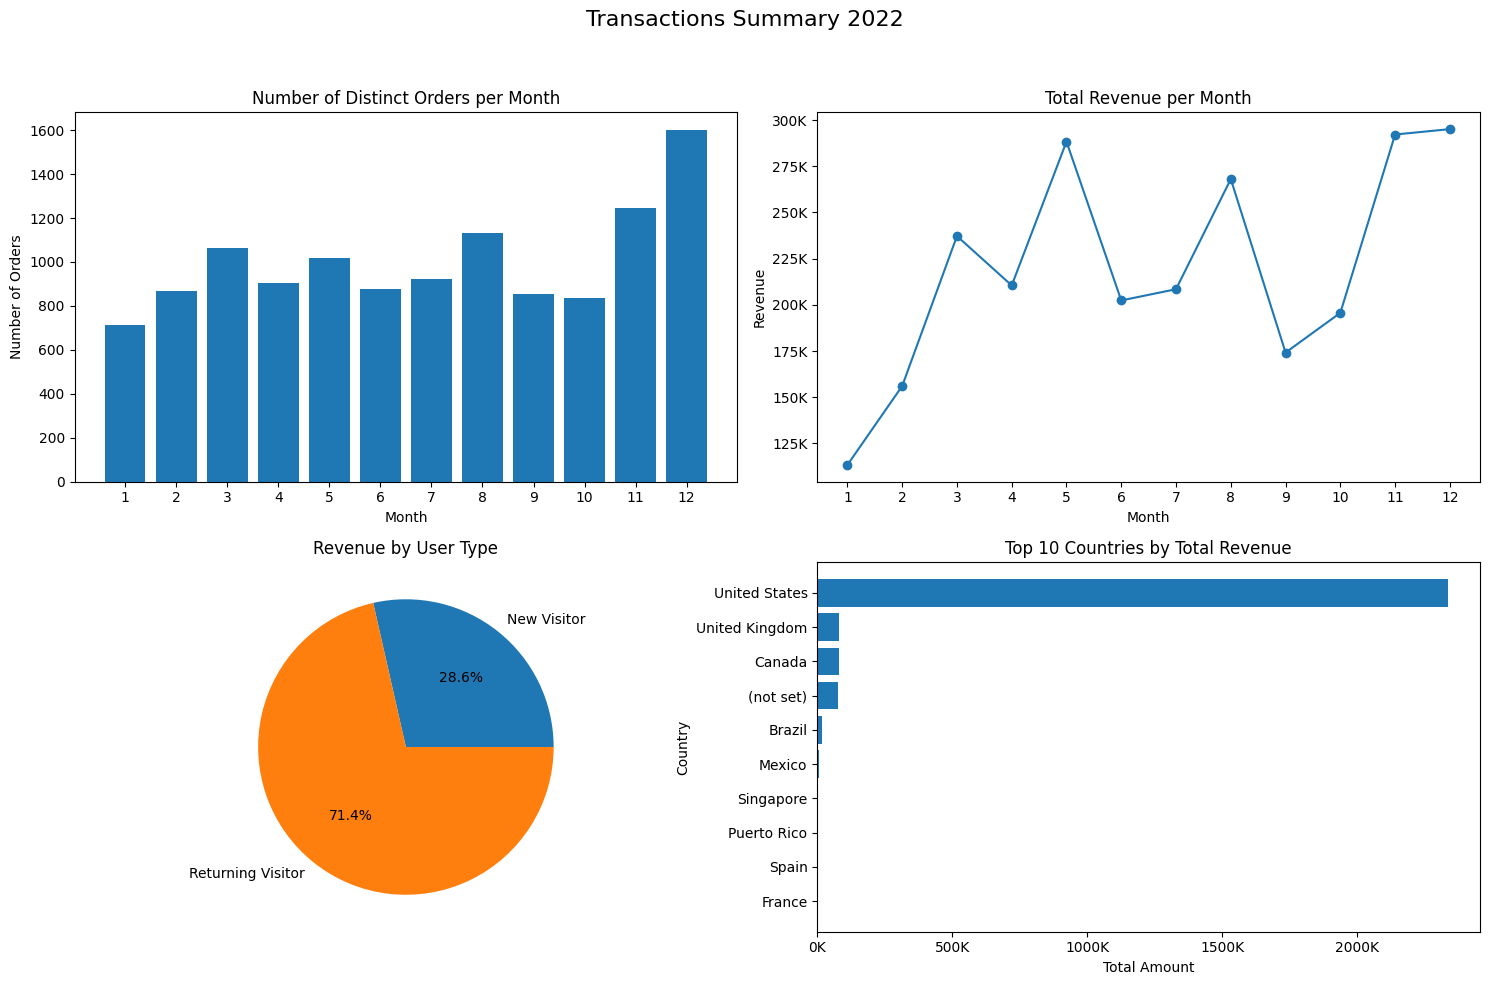

In [73]:
# Processing data for each plot
orders_per_month = transactions_view2.groupby('Month')['Transaction ID'].nunique()                                      # For Bar chart with number of distinct orders per month (0,1)
amount_per_month = transactions_view2.groupby('Month')['Amount'].sum()                                                  # For Line chart with Total Amount per month (0, 1)
amount_per_user_type = transactions_view2.groupby('User Type')['Amount'].sum()                                          # For Pie chart for User Type based on the SUM of 'Amount' (1, 0)
amount_per_country = transactions_view2.groupby('Country')['Amount'].sum().nlargest(10).sort_values(ascending=True)     # For Horiz. bar chart with top 10 countries by sum of 'Amount' (1, 1)

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
plt.subplots_adjust(wspace=0.4, hspace=0.4)

# (0, 0)
axs[0, 0].bar(orders_per_month.index.astype(str), orders_per_month)
axs[0, 0].set_title('Number of Distinct Orders per Month')
axs[0, 0].set_xlabel('Month')
axs[0, 0].set_ylabel('Number of Orders')

# (0, 1)
axs[0, 1].plot(amount_per_month.index.astype(str), amount_per_month, marker='o')
axs[0, 1].set_title('Total Revenue per Month')
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_ylabel('Revenue')
# Formatting the y-axis to show values in thousands (K)
axs[0, 1].yaxis.set_major_formatter(lambda x, pos: f'{int(x/1000)}K')

# (1, 0)
axs[1, 0].pie(amount_per_user_type, labels=amount_per_user_type.index, autopct='%1.1f%%')
axs[1, 0].set_title('Revenue by User Type')

# (1, 1)
axs[1, 1].barh(amount_per_country.index, amount_per_country)
axs[1, 1].set_title('Top 10 Countries by Total Revenue')
axs[1, 1].set_xlabel('Total Amount')
axs[1, 1].set_ylabel('Country')

# Formatting the x-axis to show values in thousands (K)
axs[1, 1].xaxis.set_major_formatter(lambda x, pos: f'{int(x/1000)}K')

# Add a title for the whole figure
plt.suptitle('Transactions Summary 2022', fontsize=16)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

------

## **6.2 - Correlation - sessions_segments**

- To analyze USER ATTRIBUTES

### **6.2.1 - Preprocessing**

In [74]:
sessions_copy = sessions_segments_df.copy()

In [75]:
data_for_analysis = sessions_copy[['Gender' , 'Age' , 'User Type' , 'Default Channel Grouping' , 'Country' , 'CountryUS_N/Y', 'Year' , 'Month' ,
                                   'Sessions' , 'Bounces', 'No_Bounce', 'Sessions Entered Checkout', 'Transactions',
                                   'Session Duration (s)', 'Page Views']]

In [76]:
data_for_analysis['Pages_per_Session'] = data_for_analysis['Page Views'] / data_for_analysis['Sessions']
data_for_analysis['Duration_per_Session'] = data_for_analysis['Session Duration (s)'] / data_for_analysis['Sessions']

data_for_analysis['Conv_1'] = np.where(data_for_analysis['Sessions'] == 0, 0, data_for_analysis['No_Bounce'] / data_for_analysis['Sessions'])
data_for_analysis['Conv_2'] = np.where(data_for_analysis['No_Bounce'] == 0, 0, data_for_analysis['Sessions Entered Checkout'] / data_for_analysis['No_Bounce'])
data_for_analysis['Conv_3'] = np.where(data_for_analysis['Sessions Entered Checkout'] == 0, 0, data_for_analysis['Transactions'] / data_for_analysis['Sessions Entered Checkout'])
data_for_analysis['Conversion_Rate'] = np.where(data_for_analysis['Sessions'] == 0, 0, data_for_analysis['Transactions'] / data_for_analysis['Sessions'])

data_for_analysis.head()

,Gender,Age,User Type,Default Channel Grouping,Country,CountryUS_N/Y,Year,Month,Sessions,Bounces,No_Bounce,Sessions Entered Checkout,Transactions,Session Duration (s),Page Views,Pages_per_Session,Duration_per_Session,Conv_1,Conv_2,Conv_3,Conversion_Rate
0,male,25-34,Returning Visitor,Paid Search,United States,1.0,19,05,206,66,140,5,1,34408,1010,4.902913,167.029126,0.679612,0.035714,0.200000,0.004854
1,male,25-34,New Visitor,Direct,United States,1.0,19,05,749,136,613,35,1,193500,4522,6.037383,258.344459,0.818425,0.057096,0.028571,0.001335
2,female,35-44,New Visitor,Organic Search,United States,1.0,19,05,257,75,182,10,2,61498,1619,6.299611,239.291829,0.708171,0.054945,0.200000,0.007782
3,female,25-34,New Visitor,Organic Search,United States,1.0,19,05,596,169,427,9,1,95030,2970,4.983221,159.446309,0.716443,0.021077,0.111111,0.001678
4,female,25-34,Returning Visitor,Organic Search,United States,1.0,19,05,329,116,213,16,2,77340,1794,5.452888,235.075988,0.647416,0.075117,0.125000,0.006079


In [77]:
# Dictionary to specify columns to rename
rename_columns = {
    'Default Channel Grouping': 'Channel'
}

data_for_analysis = data_for_analysis.rename(columns=rename_columns)

In [78]:
# Remove outlier in advance (before seeing in on boxplot)

# Should I remove this record before?

"""

data_for_analysis_filter = data_for_analysis[ data_for_analysis['Conversion_Rate'] > 1]
data_for_analysis_filter.head()

"""

"\n\ndata_for_analysis_filter = data_for_analysis[ data_for_analysis['Conversion_Rate'] > 1]\ndata_for_analysis_filter.head()\n\n"

In [87]:
# data_for_analysis = data_for_analysis[ data_for_analysis['Sessions'] > 0]

------

### **6.2.2 - Correlation**

In [79]:
data_for_corr = data_for_analysis.copy()
data_for_corr.head()

,Gender,Age,User Type,Channel,Country,CountryUS_N/Y,Year,Month,Sessions,Bounces,No_Bounce,Sessions Entered Checkout,Transactions,Session Duration (s),Page Views,Pages_per_Session,Duration_per_Session,Conv_1,Conv_2,Conv_3,Conversion_Rate
0,male,25-34,Returning Visitor,Paid Search,United States,1.0,19,05,206,66,140,5,1,34408,1010,4.902913,167.029126,0.679612,0.035714,0.200000,0.004854
1,male,25-34,New Visitor,Direct,United States,1.0,19,05,749,136,613,35,1,193500,4522,6.037383,258.344459,0.818425,0.057096,0.028571,0.001335
2,female,35-44,New Visitor,Organic Search,United States,1.0,19,05,257,75,182,10,2,61498,1619,6.299611,239.291829,0.708171,0.054945,0.200000,0.007782
3,female,25-34,New Visitor,Organic Search,United States,1.0,19,05,596,169,427,9,1,95030,2970,4.983221,159.446309,0.716443,0.021077,0.111111,0.001678
4,female,25-34,Returning Visitor,Organic Search,United States,1.0,19,05,329,116,213,16,2,77340,1794,5.452888,235.075988,0.647416,0.075117,0.125000,0.006079


In [80]:
data_for_corr['Year'] = data_for_corr['Year'].astype(int)
data_for_corr['Month'] = data_for_corr['Month'].astype(int)

In [81]:
columns_to_normalize = ['Sessions', 'No_Bounce', 'Sessions Entered Checkout', 'Transactions',
                        'Pages_per_Session','Duration_per_Session',
                        'Conv_1'	, 'Conv_2'	, 'Conv_3' ,	'Conversion_Rate']

for col in columns_to_normalize:
  min_value = data_for_corr[col].min()
  max_value = data_for_corr[col].max()
  data_for_corr[f'{col}_normalized'] = (data_for_corr[col] - min_value) / (max_value - min_value)

In [82]:
  data_for_corr.head()

,Gender,Age,User Type,Channel,Country,CountryUS_N/Y,Year,Month,Sessions,Bounces,No_Bounce,Sessions Entered Checkout,Transactions,Session Duration (s),Page Views,Pages_per_Session,Duration_per_Session,Conv_1,Conv_2,Conv_3,Conversion_Rate,Sessions_normalized,No_Bounce_normalized,Sessions Entered Checkout_normalized,Transactions_normalized,Pages_per_Session_normalized,Duration_per_Session_normalized,Conv_1_normalized,Conv_2_normalized,Conv_3_normalized,Conversion_Rate_normalized
0,male,25-34,Returning Visitor,Paid Search,United States,1.0,19,5,206,66,140,5,1,34408,1010,4.902913,167.029126,0.679612,0.035714,0.200000,0.004854,0.084084,0.093708,0.014620,0.003937,0.106081,0.087491,0.679612,0.035714,0.020690,0.002009
1,male,25-34,New Visitor,Direct,United States,1.0,19,5,749,136,613,35,1,193500,4522,6.037383,258.344459,0.818425,0.057096,0.028571,0.001335,0.317031,0.410308,0.102339,0.003937,0.136916,0.135322,0.818425,0.057096,0.002956,0.000552
2,female,35-44,New Visitor,Organic Search,United States,1.0,19,5,257,75,182,10,2,61498,1619,6.299611,239.291829,0.708171,0.054945,0.200000,0.007782,0.105963,0.121821,0.029240,0.007874,0.144044,0.125342,0.708171,0.054945,0.020690,0.003220
3,female,25-34,New Visitor,Organic Search,United States,1.0,19,5,596,169,427,9,1,95030,2970,4.983221,159.446309,0.716443,0.021077,0.111111,0.001678,0.251394,0.285810,0.026316,0.003937,0.108264,0.083519,0.716443,0.021077,0.011494,0.000694
4,female,25-34,Returning Visitor,Organic Search,United States,1.0,19,5,329,116,213,16,2,77340,1794,5.452888,235.075988,0.647416,0.075117,0.125000,0.006079,0.136851,0.142570,0.046784,0.007874,0.121030,0.123134,0.647416,0.075117,0.012931,0.002515


In [83]:
cols_to_drop = ['Country', 'Sessions', 'Bounces' , 'No_Bounce' , 'Sessions Entered Checkout' , 'Transactions' ,
                 'Session Duration (s)' , 'Page Views' , 'Pages_per_Session' , 'Duration_per_Session' ,
                 'Conv_1'	, 'Conv_2'	, 'Conv_3' ,	'Conversion_Rate']

data_for_corr = data_for_corr.drop(columns=cols_to_drop)

In [84]:
data_for_corr.head()

,Gender,Age,User Type,Channel,CountryUS_N/Y,Year,Month,Sessions_normalized,No_Bounce_normalized,Sessions Entered Checkout_normalized,Transactions_normalized,Pages_per_Session_normalized,Duration_per_Session_normalized,Conv_1_normalized,Conv_2_normalized,Conv_3_normalized,Conversion_Rate_normalized
0,male,25-34,Returning Visitor,Paid Search,1.0,19,5,0.084084,0.093708,0.014620,0.003937,0.106081,0.087491,0.679612,0.035714,0.020690,0.002009
1,male,25-34,New Visitor,Direct,1.0,19,5,0.317031,0.410308,0.102339,0.003937,0.136916,0.135322,0.818425,0.057096,0.002956,0.000552
2,female,35-44,New Visitor,Organic Search,1.0,19,5,0.105963,0.121821,0.029240,0.007874,0.144044,0.125342,0.708171,0.054945,0.020690,0.003220
3,female,25-34,New Visitor,Organic Search,1.0,19,5,0.251394,0.285810,0.026316,0.003937,0.108264,0.083519,0.716443,0.021077,0.011494,0.000694
4,female,25-34,Returning Visitor,Organic Search,1.0,19,5,0.136851,0.142570,0.046784,0.007874,0.121030,0.123134,0.647416,0.075117,0.012931,0.002515


In [85]:
# Rename columns
data_for_corr.columns = ['Gender' , 'Age' , 'User Type' , 'Channel' , 'CountryUS_N/Y' , 'Year' , 'Month' ,
                         'Sessions', 'No_Bounce' , 'Checkout' , 'Transactions' , 'Pages/Session' , 'Duration/Session' ,
                         'Conv_1' , 'Conv_2' , 'Conv_3' , 'Conversion_Rate']

In [86]:
data_for_corr.head()

,Gender,Age,User Type,Channel,CountryUS_N/Y,Year,Month,Sessions,No_Bounce,Checkout,Transactions,Pages/Session,Duration/Session,Conv_1,Conv_2,Conv_3,Conversion_Rate
0,male,25-34,Returning Visitor,Paid Search,1.0,19,5,0.084084,0.093708,0.014620,0.003937,0.106081,0.087491,0.679612,0.035714,0.020690,0.002009
1,male,25-34,New Visitor,Direct,1.0,19,5,0.317031,0.410308,0.102339,0.003937,0.136916,0.135322,0.818425,0.057096,0.002956,0.000552
2,female,35-44,New Visitor,Organic Search,1.0,19,5,0.105963,0.121821,0.029240,0.007874,0.144044,0.125342,0.708171,0.054945,0.020690,0.003220
3,female,25-34,New Visitor,Organic Search,1.0,19,5,0.251394,0.285810,0.026316,0.003937,0.108264,0.083519,0.716443,0.021077,0.011494,0.000694
4,female,25-34,Returning Visitor,Organic Search,1.0,19,5,0.136851,0.142570,0.046784,0.007874,0.121030,0.123134,0.647416,0.075117,0.012931,0.002515


In [87]:
copy1 = data_for_corr.copy()

In [88]:
columns_to_encode1 = ['Gender' , 'Age' , 'User Type' , 'Channel' , 'CountryUS_N/Y']

df_encoded1 = pd.get_dummies(copy1, columns=columns_to_encode1)

df_encoded1.head()

,Year,Month,Sessions,No_Bounce,Checkout,Transactions,Pages/Session,Duration/Session,Conv_1,Conv_2,Conv_3,Conversion_Rate,Gender_female,Gender_male,Age_18-24,Age_25-34,Age_35-44,Age_45-54,Age_55-64,Age_65+,User Type_New Visitor,User Type_Returning Visitor,Channel_(Other),Channel_Affiliates,Channel_Direct,Channel_Display,Channel_Organic Search,Channel_Paid Search,Channel_Referral,Channel_Social,CountryUS_N/Y_0.0,CountryUS_N/Y_1.0
0,19,5,0.084084,0.093708,0.014620,0.003937,0.106081,0.087491,0.679612,0.035714,0.020690,0.002009,False,True,False,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False,False,True
1,19,5,0.317031,0.410308,0.102339,0.003937,0.136916,0.135322,0.818425,0.057096,0.002956,0.000552,False,True,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True
2,19,5,0.105963,0.121821,0.029240,0.007874,0.144044,0.125342,0.708171,0.054945,0.020690,0.003220,True,False,False,False,True,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
3,19,5,0.251394,0.285810,0.026316,0.003937,0.108264,0.083519,0.716443,0.021077,0.011494,0.000694,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,True
4,19,5,0.136851,0.142570,0.046784,0.007874,0.121030,0.123134,0.647416,0.075117,0.012931,0.002515,True,False,False,True,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,True


In [89]:
correlation_matrix = df_encoded1.corr()

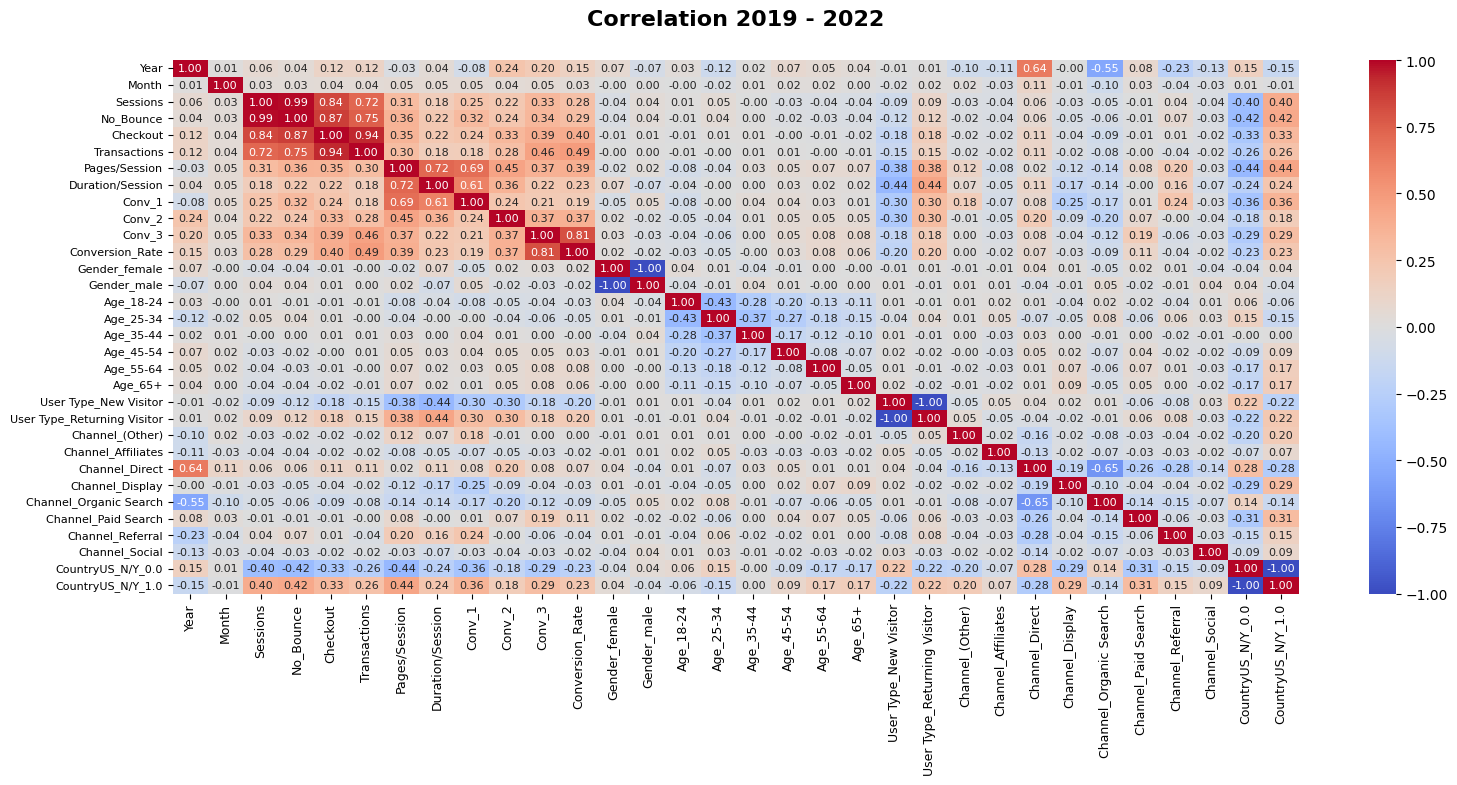

In [90]:
plt.figure(figsize=(16,8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',  # Format the coefficients to two decimal places
    annot_kws={'fontsize': 8}  # Set the font size for the annotations
)
plt.title('Correlation 2019 - 2022', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y=1.05)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

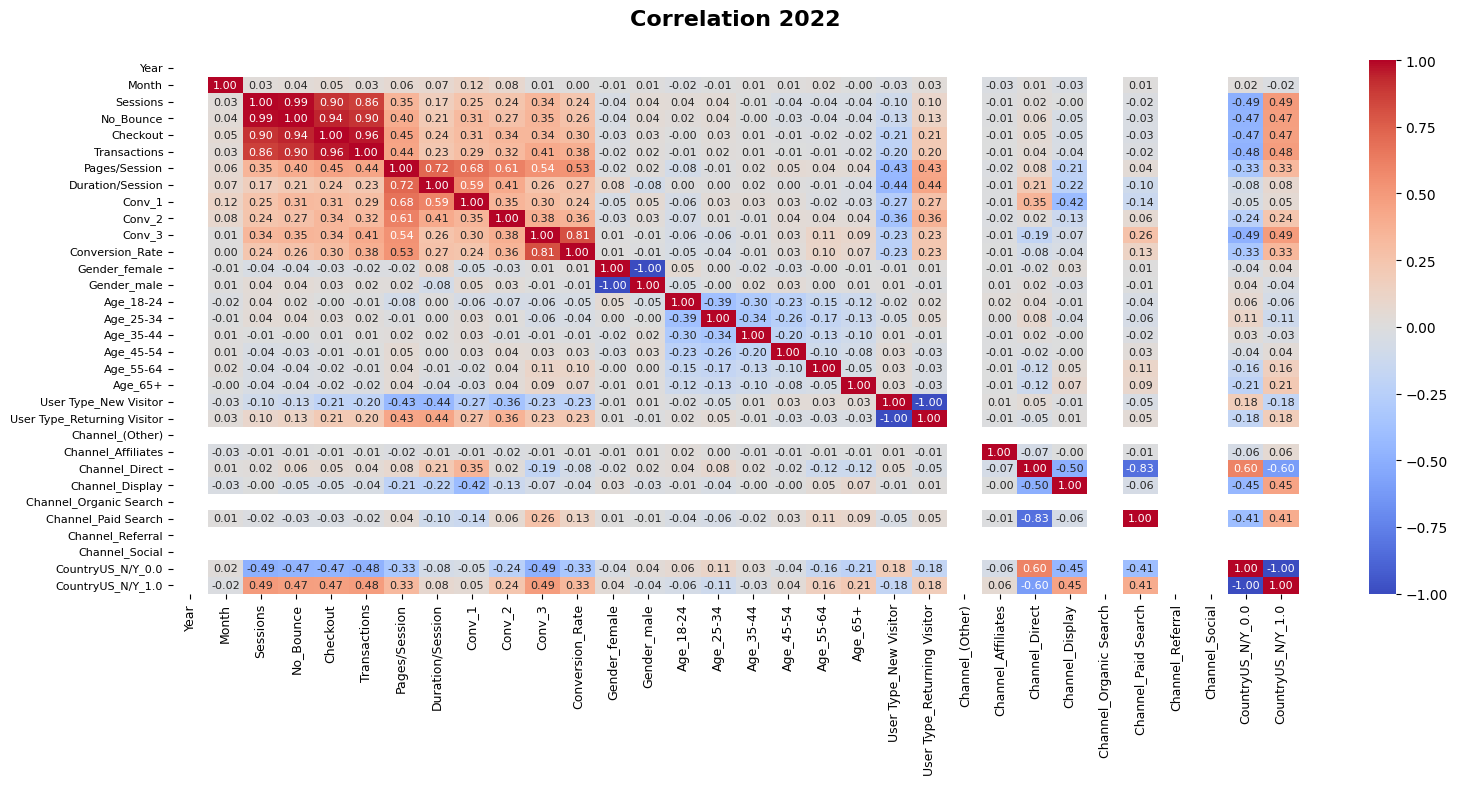

In [91]:
datacorr2022 = df_encoded1[df_encoded1['Year'] == 22]
correlation_mat2022 = datacorr2022.corr()

plt.figure(figsize=(16,8))
sns.heatmap(
    correlation_mat2022,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    annot_kws={'fontsize': 8}
)
plt.title('Correlation 2022', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y=1.05)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

-------

## **6.3 - Correlation - all_sessions**

- To analyze TECHNICAL ATTRIBUTES

### **6.3.1 - Preprocessing**

In [92]:
all_sessions_copy = all_sessions_df.copy()

# THE OLD
# sessions_copy = sessions_segments_df.copy()

In [93]:
all_sessions_copy.head() # sessions_copy() will be used for the Time Series Analysis

,Country,CountryUS_N/Y,Source,SourceDirect_N/Y,Medium,Campaign,Campaign_N/Y,Device Category,User Type,Year,Month,Total Sales,Sessions,Bounces,No_Bounce,Sessions Entered Checkout,Transactions,Page Views,Session Duration (s)
0,United States,1.0,(direct),1.0,(none),(not set),0.0,desktop,Returning Visitor,22,08,147135.16,13619,3213,10406,1977,1145,132564,4754172
1,United Kingdom,0.0,(direct),1.0,(none),(not set),0.0,desktop,Returning Visitor,22,08,16615.60,1224,423,801,93,43,7299,316086
2,United States,1.0,google,0.0,cpc,MIX | Txt ~ AW-Brand (US/Cali),1.0,desktop,Returning Visitor,22,08,6047.08,850,198,652,91,59,7426,277133
3,United States,1.0,(direct),1.0,(none),(not set),0.0,mobile,Returning Visitor,22,08,3801.69,1678,965,713,70,45,7650,278144
4,Canada,0.0,(direct),1.0,(none),(not set),0.0,desktop,Returning Visitor,22,08,3048.12,792,245,547,124,25,7198,316426


In [94]:
data_for_analysis_all = all_sessions_copy[['Country' , 'CountryUS_N/Y', 'Medium' , 'Source' , 'SourceDirect_N/Y' ,
                                           'Campaign' , 'Campaign_N/Y', 'Device Category' , 'User Type' ,
                                           'Year' , 'Month' , 'Sessions' , 'Bounces', 'No_Bounce', 'Sessions Entered Checkout', 'Transactions',
                                           'Session Duration (s)', 'Page Views']]

In [95]:
data_for_analysis_all['Pages_per_Session'] = data_for_analysis_all['Page Views'] / data_for_analysis_all['Sessions']
data_for_analysis_all['Duration_per_Session'] = data_for_analysis_all['Session Duration (s)'] / data_for_analysis_all['Sessions']

# data_for_analysis_all['Conv_1'] = data_for_analysis_all['No_Bounce'] / data_for_analysis_all['Sessions']
data_for_analysis_all['Conv_1'] = np.where(data_for_analysis_all['Sessions'] == 0, 0, data_for_analysis_all['No_Bounce'] / data_for_analysis_all['Sessions'])

# data_for_analysis_all['Conv_2'] = data_for_analysis_all['Sessions Entered Checkout'] / data_for_analysis_all['No_Bounce']
data_for_analysis_all['Conv_2'] = np.where(data_for_analysis_all['No_Bounce'] == 0, 0, data_for_analysis_all['Sessions Entered Checkout'] / data_for_analysis_all['No_Bounce'])

# data_for_analysis_all['Conv_3'] = data_for_analysis_all['Transactions'] / data_for_analysis_all['Sessions Entered Checkout']
data_for_analysis_all['Conv_3'] = np.where(data_for_analysis_all['Sessions Entered Checkout'] == 0, 0, data_for_analysis_all['Transactions'] / data_for_analysis_all['Sessions Entered Checkout'])

# data_for_analysis_all['Conversion_Rate'] = data_for_analysis_all['Transactions'] / data_for_analysis_all['Sessions']
data_for_analysis_all['Conversion_Rate'] = np.where(data_for_analysis_all['Sessions'] == 0, 0, data_for_analysis_all['Transactions'] / data_for_analysis_all['Sessions'])

data_for_analysis_all.head()

,Country,CountryUS_N/Y,Medium,Source,SourceDirect_N/Y,Campaign,Campaign_N/Y,Device Category,User Type,Year,Month,Sessions,Bounces,No_Bounce,Sessions Entered Checkout,Transactions,Session Duration (s),Page Views,Pages_per_Session,Duration_per_Session,Conv_1,Conv_2,Conv_3,Conversion_Rate
0,United States,1.0,(none),(direct),1.0,(not set),0.0,desktop,Returning Visitor,22,08,13619,3213,10406,1977,1145,4754172,132564,9.733754,349.083780,0.764080,0.189987,0.579160,0.084074
1,United Kingdom,0.0,(none),(direct),1.0,(not set),0.0,desktop,Returning Visitor,22,08,1224,423,801,93,43,316086,7299,5.963235,258.240196,0.654412,0.116105,0.462366,0.035131
2,United States,1.0,cpc,google,0.0,MIX | Txt ~ AW-Brand (US/Cali),1.0,desktop,Returning Visitor,22,08,850,198,652,91,59,277133,7426,8.736471,326.038824,0.767059,0.139571,0.648352,0.069412
3,United States,1.0,(none),(direct),1.0,(not set),0.0,mobile,Returning Visitor,22,08,1678,965,713,70,45,278144,7650,4.558999,165.759237,0.424911,0.098177,0.642857,0.026818
4,Canada,0.0,(none),(direct),1.0,(not set),0.0,desktop,Returning Visitor,22,08,792,245,547,124,25,316426,7198,9.088384,399.527778,0.690657,0.226691,0.201613,0.031566


In [ ]:
"""

########################### SHOULD I REMOVE THIS RECORD ? ###########################################
data_for_analysis_filter = data_for_analysis_all[ data_for_analysis_all['Conversion_Rate'] > 1]
########################### SHOULD I REMOVE THIS RECORD ? ###########################################
data_for_analysis_filter.head()

"""

"\n\n########################### SHOULD I REMOVE THIS RECORD ? ###########################################\ndata_for_analysis_filter = data_for_analysis_all[ data_for_analysis_all['Conversion_Rate'] > 1]\n########################### SHOULD I REMOVE THIS RECORD ? ###########################################\ndata_for_analysis_filter.head()\n\n"

------

### **6.3.2 - Correlation**

In [96]:
data_for_corr_all = data_for_analysis_all.copy()
data_for_corr_all.head()

,Country,CountryUS_N/Y,Medium,Source,SourceDirect_N/Y,Campaign,Campaign_N/Y,Device Category,User Type,Year,Month,Sessions,Bounces,No_Bounce,Sessions Entered Checkout,Transactions,Session Duration (s),Page Views,Pages_per_Session,Duration_per_Session,Conv_1,Conv_2,Conv_3,Conversion_Rate
0,United States,1.0,(none),(direct),1.0,(not set),0.0,desktop,Returning Visitor,22,08,13619,3213,10406,1977,1145,4754172,132564,9.733754,349.083780,0.764080,0.189987,0.579160,0.084074
1,United Kingdom,0.0,(none),(direct),1.0,(not set),0.0,desktop,Returning Visitor,22,08,1224,423,801,93,43,316086,7299,5.963235,258.240196,0.654412,0.116105,0.462366,0.035131
2,United States,1.0,cpc,google,0.0,MIX | Txt ~ AW-Brand (US/Cali),1.0,desktop,Returning Visitor,22,08,850,198,652,91,59,277133,7426,8.736471,326.038824,0.767059,0.139571,0.648352,0.069412
3,United States,1.0,(none),(direct),1.0,(not set),0.0,mobile,Returning Visitor,22,08,1678,965,713,70,45,278144,7650,4.558999,165.759237,0.424911,0.098177,0.642857,0.026818
4,Canada,0.0,(none),(direct),1.0,(not set),0.0,desktop,Returning Visitor,22,08,792,245,547,124,25,316426,7198,9.088384,399.527778,0.690657,0.226691,0.201613,0.031566


In [97]:
data_for_corr_all['Year'] = data_for_corr_all['Year'].astype(int)
data_for_corr_all['Month'] = data_for_corr_all['Month'].astype(int)

In [98]:
columns_to_normalize = ['Sessions', 'No_Bounce', 'Sessions Entered Checkout', 'Transactions',
                        'Pages_per_Session','Duration_per_Session',
                        'Conv_1'	, 'Conv_2'	, 'Conv_3' ,	'Conversion_Rate']

for col in columns_to_normalize:
  min_value = data_for_corr_all[col].min()
  max_value = data_for_corr_all[col].max()
  data_for_corr_all[f'{col}_normalized'] = (data_for_corr_all[col] - min_value) / (max_value - min_value)

In [99]:
data_for_corr_all.head()

,Country,CountryUS_N/Y,Medium,Source,SourceDirect_N/Y,Campaign,Campaign_N/Y,Device Category,User Type,Year,Month,Sessions,Bounces,No_Bounce,Sessions Entered Checkout,Transactions,Session Duration (s),Page Views,Pages_per_Session,Duration_per_Session,Conv_1,Conv_2,Conv_3,Conversion_Rate,Sessions_normalized,No_Bounce_normalized,Sessions Entered Checkout_normalized,Transactions_normalized,Pages_per_Session_normalized,Duration_per_Session_normalized,Conv_1_normalized,Conv_2_normalized,Conv_3_normalized,Conversion_Rate_normalized
0,United States,1.0,(none),(direct),1.0,(not set),0.0,desktop,Returning Visitor,22,8,13619,3213,10406,1977,1145,4754172,132564,9.733754,349.083780,0.764080,0.189987,0.579160,0.084074,0.798991,0.857096,0.778653,0.544719,0.038935,0.038791,0.764080,0.189987,0.072395,0.010509
1,United Kingdom,0.0,(none),(direct),1.0,(not set),0.0,desktop,Returning Visitor,22,8,1224,423,801,93,43,316086,7299,5.963235,258.240196,0.654412,0.116105,0.462366,0.035131,0.071755,0.065975,0.036629,0.020457,0.023853,0.028697,0.654412,0.116105,0.057796,0.004391
2,United States,1.0,cpc,google,0.0,MIX | Txt ~ AW-Brand (US/Cali),1.0,desktop,Returning Visitor,22,8,850,198,652,91,59,277133,7426,8.736471,326.038824,0.767059,0.139571,0.648352,0.069412,0.049812,0.053702,0.035841,0.028069,0.034946,0.036231,0.767059,0.139571,0.081044,0.008676
3,United States,1.0,(none),(direct),1.0,(not set),0.0,mobile,Returning Visitor,22,8,1678,965,713,70,45,278144,7650,4.558999,165.759237,0.424911,0.098177,0.642857,0.026818,0.098392,0.058727,0.027570,0.021408,0.018236,0.018420,0.424911,0.098177,0.080357,0.003352
4,Canada,0.0,(none),(direct),1.0,(not set),0.0,desktop,Returning Visitor,22,8,792,245,547,124,25,316426,7198,9.088384,399.527778,0.690657,0.226691,0.201613,0.031566,0.046409,0.045054,0.048838,0.011893,0.036354,0.044397,0.690657,0.226691,0.025202,0.003946


In [100]:
cols_to_drop = ['Country' , 'Source' , 'Campaign' ,
                 'Sessions' , 'Bounces' , 'Sessions Entered Checkout' , 'Transactions' ,
                 'Session Duration (s)' , 'Page Views' , 'No_Bounce' , 'Pages_per_Session' , 'Duration_per_Session' ,
                 'Conv_1'	, 'Conv_2'	, 'Conv_3' ,	'Conversion_Rate']

data_for_corr_all = data_for_corr_all.drop(columns=cols_to_drop)

In [101]:
data_for_corr_all.head()

,CountryUS_N/Y,Medium,SourceDirect_N/Y,Campaign_N/Y,Device Category,User Type,Year,Month,Sessions_normalized,No_Bounce_normalized,Sessions Entered Checkout_normalized,Transactions_normalized,Pages_per_Session_normalized,Duration_per_Session_normalized,Conv_1_normalized,Conv_2_normalized,Conv_3_normalized,Conversion_Rate_normalized
0,1.0,(none),1.0,0.0,desktop,Returning Visitor,22,8,0.798991,0.857096,0.778653,0.544719,0.038935,0.038791,0.764080,0.189987,0.072395,0.010509
1,0.0,(none),1.0,0.0,desktop,Returning Visitor,22,8,0.071755,0.065975,0.036629,0.020457,0.023853,0.028697,0.654412,0.116105,0.057796,0.004391
2,1.0,cpc,0.0,1.0,desktop,Returning Visitor,22,8,0.049812,0.053702,0.035841,0.028069,0.034946,0.036231,0.767059,0.139571,0.081044,0.008676
3,1.0,(none),1.0,0.0,mobile,Returning Visitor,22,8,0.098392,0.058727,0.027570,0.021408,0.018236,0.018420,0.424911,0.098177,0.080357,0.003352
4,0.0,(none),1.0,0.0,desktop,Returning Visitor,22,8,0.046409,0.045054,0.048838,0.011893,0.036354,0.044397,0.690657,0.226691,0.025202,0.003946


In [102]:
# Rename columns
data_for_corr_all.columns = ['CountryUS_N/Y', 'Medium' , 'SourceDirect_N/Y' , 'Campaign_N/Y' , 'Device Category' ,	'User Type' ,
                             'Year' ,	'Month' ,	'Sessions', 'No_Bounce' , 'Checkout' , 'Transactions' , 'Pages/Session' , 'Duration/Session' ,
                             'Conv_1' , 'Conv_2' , 'Conv_3' , 'Conversion_Rate']

In [103]:
data_for_corr_all.head()

,CountryUS_N/Y,Medium,SourceDirect_N/Y,Campaign_N/Y,Device Category,User Type,Year,Month,Sessions,No_Bounce,Checkout,Transactions,Pages/Session,Duration/Session,Conv_1,Conv_2,Conv_3,Conversion_Rate
0,1.0,(none),1.0,0.0,desktop,Returning Visitor,22,8,0.798991,0.857096,0.778653,0.544719,0.038935,0.038791,0.764080,0.189987,0.072395,0.010509
1,0.0,(none),1.0,0.0,desktop,Returning Visitor,22,8,0.071755,0.065975,0.036629,0.020457,0.023853,0.028697,0.654412,0.116105,0.057796,0.004391
2,1.0,cpc,0.0,1.0,desktop,Returning Visitor,22,8,0.049812,0.053702,0.035841,0.028069,0.034946,0.036231,0.767059,0.139571,0.081044,0.008676
3,1.0,(none),1.0,0.0,mobile,Returning Visitor,22,8,0.098392,0.058727,0.027570,0.021408,0.018236,0.018420,0.424911,0.098177,0.080357,0.003352
4,0.0,(none),1.0,0.0,desktop,Returning Visitor,22,8,0.046409,0.045054,0.048838,0.011893,0.036354,0.044397,0.690657,0.226691,0.025202,0.003946


In [104]:
copy = data_for_corr_all.copy()

In [105]:
columns_to_encode = ['CountryUS_N/Y', 'Medium', 'SourceDirect_N/Y', 'Campaign_N/Y',  'Device Category', 'User Type']

df_encoded = pd.get_dummies(copy, columns=columns_to_encode)

df_encoded.head()

,Year,Month,Sessions,No_Bounce,Checkout,Transactions,Pages/Session,Duration/Session,Conv_1,Conv_2,Conv_3,Conversion_Rate,CountryUS_N/Y_0.0,CountryUS_N/Y_1.0,Medium_(none),Medium_(not set),Medium_affiliate,Medium_cpc,Medium_cpm,Medium_organic,Medium_referral,SourceDirect_N/Y_0.0,SourceDirect_N/Y_1.0,Campaign_N/Y_0.0,Campaign_N/Y_1.0,Device Category_desktop,Device Category_mobile,Device Category_tablet,User Type_New Visitor,User Type_Returning Visitor
0,22,8,0.798991,0.857096,0.778653,0.544719,0.038935,0.038791,0.764080,0.189987,0.072395,0.010509,False,True,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True
1,22,8,0.071755,0.065975,0.036629,0.020457,0.023853,0.028697,0.654412,0.116105,0.057796,0.004391,True,False,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True
2,22,8,0.049812,0.053702,0.035841,0.028069,0.034946,0.036231,0.767059,0.139571,0.081044,0.008676,False,True,False,False,False,True,False,False,False,True,False,False,True,True,False,False,False,True
3,22,8,0.098392,0.058727,0.027570,0.021408,0.018236,0.018420,0.424911,0.098177,0.080357,0.003352,False,True,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,True
4,22,8,0.046409,0.045054,0.048838,0.011893,0.036354,0.044397,0.690657,0.226691,0.025202,0.003946,True,False,True,False,False,False,False,False,False,False,True,True,False,True,False,False,False,True


In [106]:
# Calculate the correlation matrix, including both numerical and encoded columns
correlation_matrix_all = df_encoded.corr()

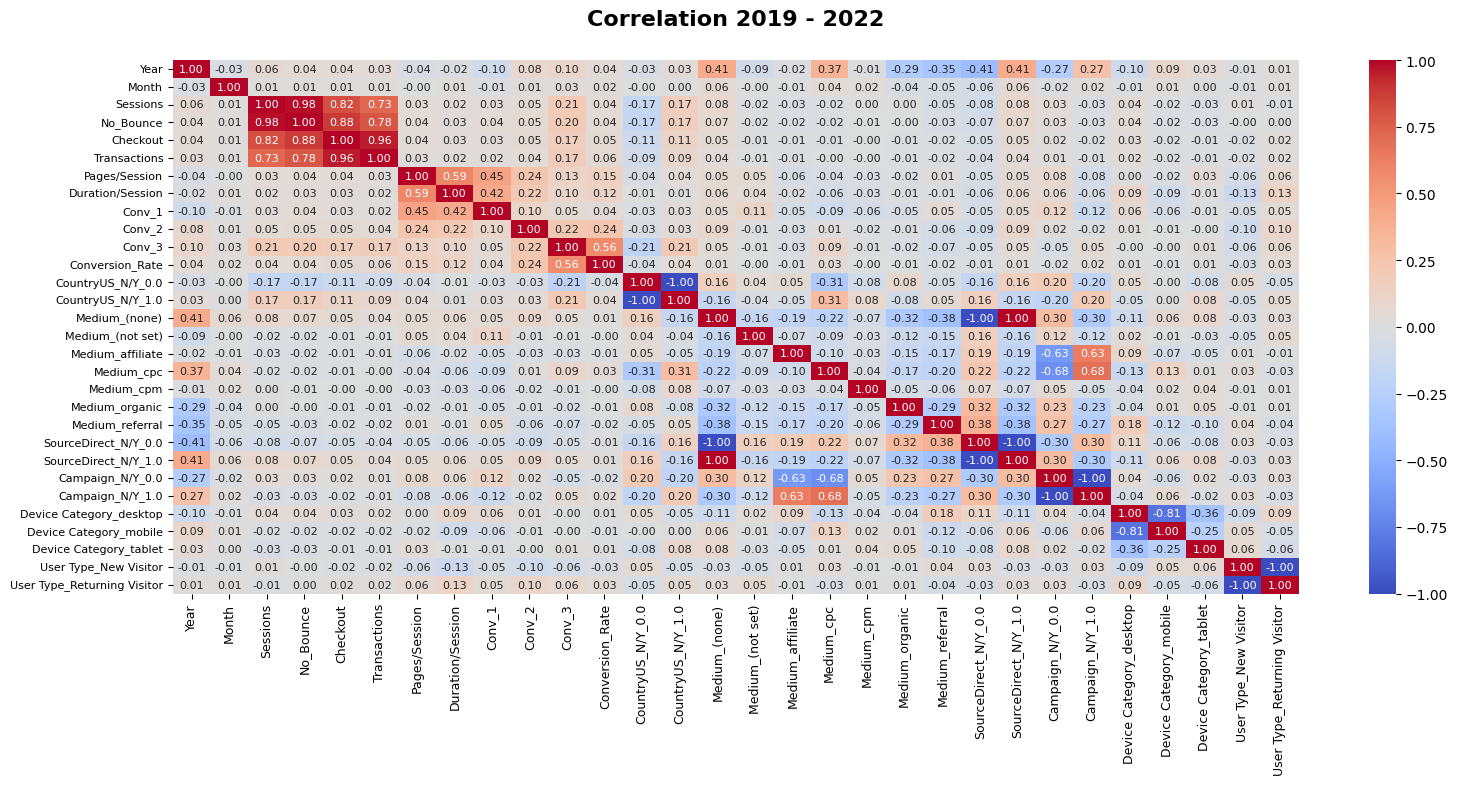

In [107]:
plt.figure(figsize=(16,8))
sns.heatmap(
    correlation_matrix_all,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',  # Format the coefficients to two decimal places
    annot_kws={'fontsize': 8}  # Set the font size for the annotations
)
plt.title('Correlation 2019 - 2022', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y=1.05)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

------

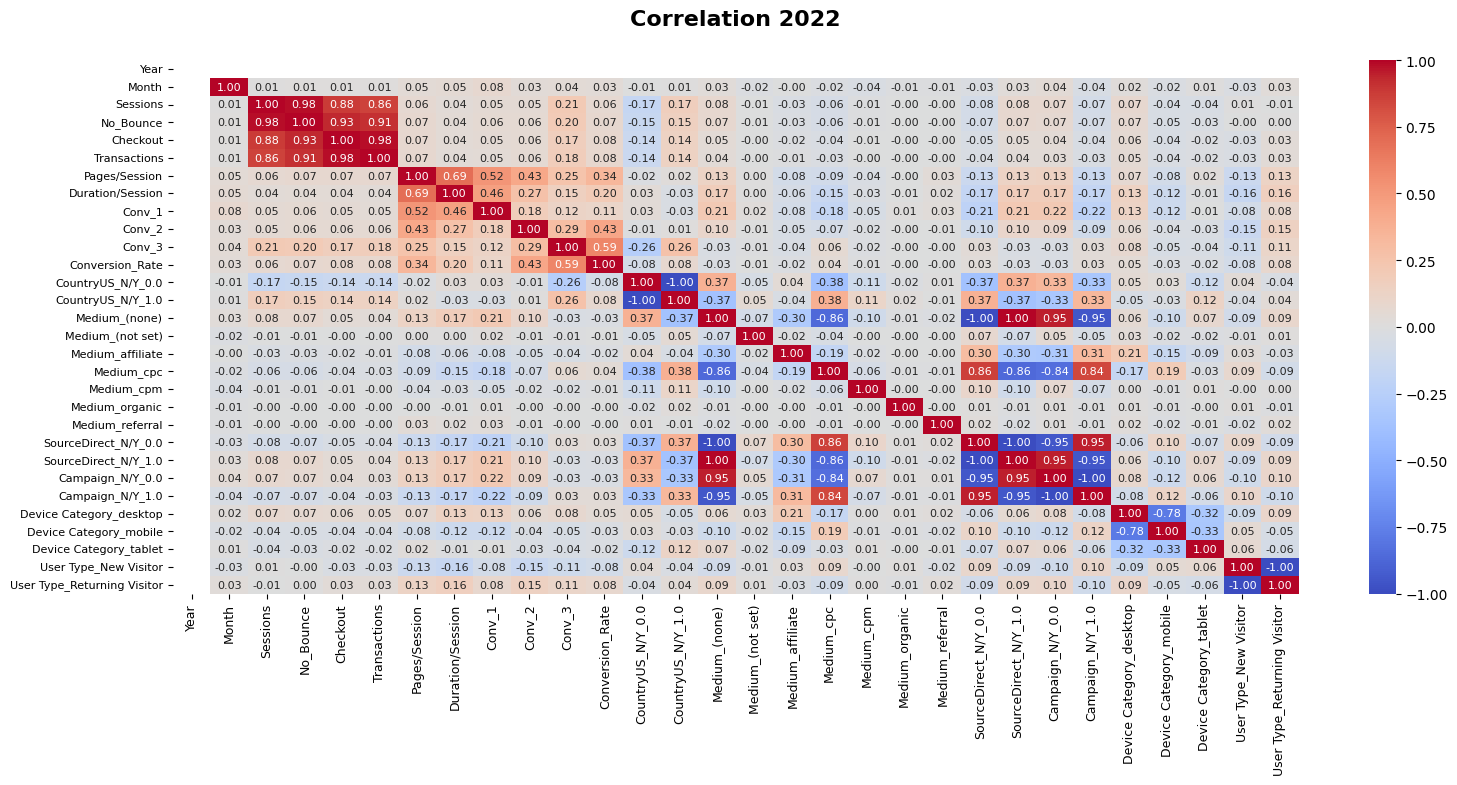

In [108]:
dataforcorr2022 = df_encoded[df_encoded['Year'] == 22]
correlation_matrix2022 = dataforcorr2022.corr()

plt.figure(figsize=(16,8))
sns.heatmap(
    correlation_matrix2022,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',  # Format the coefficients to two decimal places
    annot_kws={'fontsize': 8}  # Set the font size for the annotations
)
plt.title('Correlation 2022', fontdict={'fontsize': 16, 'fontweight': 'bold'}, y=1.05)
plt.xticks(rotation=90, fontsize=9)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

-------

## **6.4 - t-test**

t-test to validate difference between the 2 USER TYPES

In [109]:
data_for_ttest = all_sessions_df.copy()

In [110]:
data_for_ttest['Conversion_Rate'] = np.where(data_for_ttest['Sessions'] == 0, 0, data_for_ttest['Transactions'] / data_for_ttest['Sessions'])

In [111]:
data_for_ttest = data_for_ttest[['User Type' , 'Conversion_Rate']]

In [112]:
data_for_ttest.head()

,User Type,Conversion_Rate
0,Returning Visitor,0.084074
1,Returning Visitor,0.035131
2,Returning Visitor,0.069412
3,Returning Visitor,0.026818
4,Returning Visitor,0.031566


In [113]:
ReturningVisitor_ConvRate = data_for_ttest[data_for_ttest['User Type'] == 'Returning Visitor']['Conversion_Rate']
NewVisitor_ConvRate = data_for_ttest[data_for_ttest['User Type'] == 'New Visitor']['Conversion_Rate']

In [114]:
print(f"Returning Visitor records: {ReturningVisitor_ConvRate.shape[0]}")
print(f"New Visitor records: {NewVisitor_ConvRate.shape[0]}")

Returning Visitor records: 27568
New Visitor records: 53246


In [115]:
# t-test

t_stat1 , p_val_1 = stats.ttest_ind(ReturningVisitor_ConvRate,NewVisitor_ConvRate)
print(f"Returning Visitor   vs   New Visitor:   t-stat = {t_stat1} , p_val = {p_val_1}")

Returning Visitor   vs   New Visitor:   t-stat = 9.178861680430485 , p_val = 4.455693197643064e-20


In [116]:
# Kruskal-Wallis test

H_stat, p_val = stats.kruskal(ReturningVisitor_ConvRate, NewVisitor_ConvRate)

# Print the results
print(f"Returning Visitor   vs   New Visitor:   H-statistic = {H_stat}, p-value = {p_val}")

Returning Visitor   vs   New Visitor:   H-statistic = 372.64842395021753, p-value = 4.960844355561168e-83


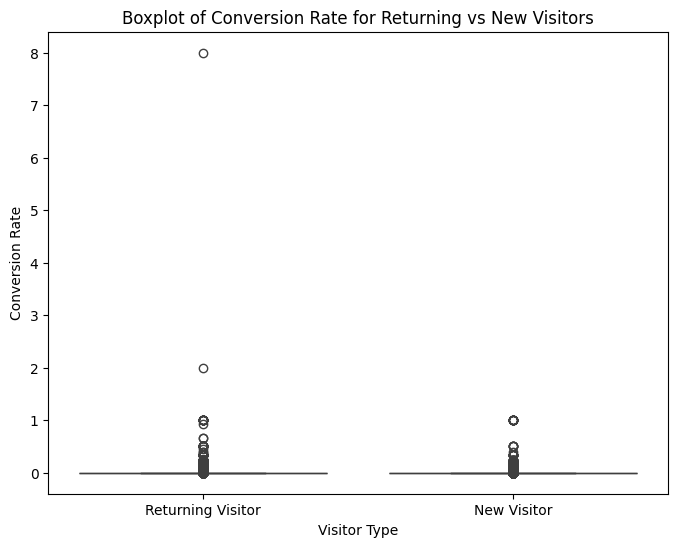

In [117]:
# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='User Type', y='Conversion_Rate', data=data_for_ttest)
plt.title('Boxplot of Conversion Rate for Returning vs New Visitors')
plt.xlabel('Visitor Type')
plt.ylabel('Conversion Rate')
plt.show()

In [118]:
# Remove outliers
data_for_ttest_wo_outliers = data_for_ttest[ data_for_ttest['Conversion_Rate'] <= 1]

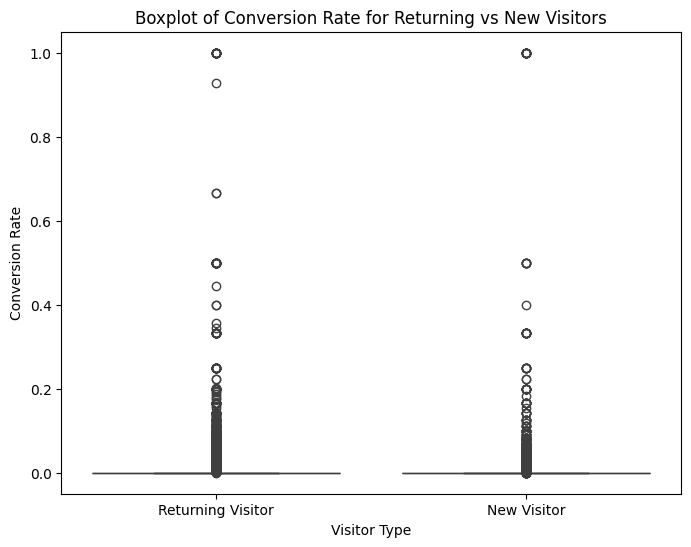

In [119]:
# Plotting with Seaborn
plt.figure(figsize=(8, 6))
sns.boxplot(x='User Type', y='Conversion_Rate', data=data_for_ttest_wo_outliers)
plt.title('Boxplot of Conversion Rate for Returning vs New Visitors')
plt.xlabel('Visitor Type')
plt.ylabel('Conversion Rate')
plt.show()

In [120]:
ReturningVisitor_ConvRate2 = data_for_ttest_wo_outliers[data_for_ttest_wo_outliers['User Type'] == 'Returning Visitor']['Conversion_Rate']
NewVisitor_ConvRate2 = data_for_ttest_wo_outliers[data_for_ttest_wo_outliers['User Type'] == 'New Visitor']['Conversion_Rate']

In [121]:
# t-test: Should show a higher variation comparing to the sample with outliers

t_stat2 , p_val_2 = stats.ttest_ind(ReturningVisitor_ConvRate2,NewVisitor_ConvRate2)
print(f"Returning Visitor   vs   New Visitor:   t-stat = {t_stat2} , p_val = {p_val_2}")

Returning Visitor   vs   New Visitor:   t-stat = 12.447616001525715 , p_val = 1.5532721885274895e-35


In [122]:
# Kruskal-Wallis test
H_stat2, p_val2 = stats.kruskal(ReturningVisitor_ConvRate2, NewVisitor_ConvRate2)

# Print the results
print(f"Returning Visitor   vs   New Visitor:   H-statistic = {H_stat2}, p-value = {p_val2}")

Returning Visitor   vs   New Visitor:   H-statistic = 370.5864665227188, p-value = 1.394769479845865e-82


--------

## **6.5 - Conversion Rate (Time Series with Machine Learning)**

### **6.5.1 - Creating Segments**

In [123]:
predict1 = all_sessions_copy.copy()

In [124]:
predict1 = predict1[ predict1['Sessions'] > 0 ]

In [125]:
predict1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80814 entries, 0 to 80813
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Country                    80814 non-null  object 
 1   CountryUS_N/Y              80814 non-null  float64
 2   Source                     80814 non-null  object 
 3   SourceDirect_N/Y           80814 non-null  float64
 4   Medium                     80814 non-null  object 
 5   Campaign                   80814 non-null  object 
 6   Campaign_N/Y               80814 non-null  float64
 7   Device Category            80814 non-null  object 
 8   User Type                  80814 non-null  object 
 9   Year                       80814 non-null  object 
 10  Month                      80814 non-null  object 
 11  Total Sales                80814 non-null  float64
 12  Sessions                   80814 non-null  int64  
 13  Bounces                    80814 non-null  int

In [126]:
# Making 4 segments

for index, row in predict1.iterrows():

# For US - New Visitor

  if (row['Country'] == "United States")  &  (row['User Type'] == "New Visitor"):
    predict1.loc[index, 'Segment_ID'] = 1
    predict1.loc[index, 'Segment_Description'] = "US_NewVisitor"

# For US - Returning Visitor

  elif (row['Country'] == "United States")  &  (row['User Type'] == "Returning Visitor"):
    predict1.loc[index, 'Segment_ID'] = 2
    predict1.loc[index, 'Segment_Description'] = "US_ReturningVisitor"


# For Non-US - New Visitor

  elif (row['Country'] != "United States")  &  (row['User Type'] == "New Visitor"):
    predict1.loc[index, 'Segment_ID'] = 3
    predict1.loc[index, 'Segment_Description'] = "Non-US_NewVisitor"


# For Non-US - Returning Visitor

  elif (row['Country'] != "United States")  &  (row['User Type'] == "Returning Visitor"):
    predict1.loc[index, 'Segment_ID'] = 4
    predict1.loc[index, 'Segment_Description'] = "Non-US_ReturningVisitor"


# In case there are other cases (ERRORS on data)

  else:

    predict1.loc[index, 'Segment_ID'] = 0
    predict1.loc[index, 'Segment_Description'] = "Mix"

In [127]:
predict1['Segment_ID'].value_counts()

Segment_ID
3.0    49544
4.0    24859
1.0     3702
2.0     2709
Name: count, dtype: int64

In [128]:
predict1['Segment_Description'].value_counts()

Segment_Description
Non-US_NewVisitor          49544
Non-US_ReturningVisitor    24859
US_NewVisitor               3702
US_ReturningVisitor         2709
Name: count, dtype: int64

-------

### **6.5.2 - Data shaping for ML**

In [129]:
predict1['Year_Month'] = '20' + predict1['Year'].astype(str) + '-' + predict1['Month'].astype(str)

In [130]:
predict1.head()

,Country,CountryUS_N/Y,Source,SourceDirect_N/Y,Medium,Campaign,Campaign_N/Y,Device Category,User Type,Year,Month,Total Sales,Sessions,Bounces,No_Bounce,Sessions Entered Checkout,Transactions,Page Views,Session Duration (s),Segment_ID,Segment_Description,Year_Month
0,United States,1.0,(direct),1.0,(none),(not set),0.0,desktop,Returning Visitor,22,08,147135.16,13619,3213,10406,1977,1145,132564,4754172,2.0,US_ReturningVisitor,2022-08
1,United Kingdom,0.0,(direct),1.0,(none),(not set),0.0,desktop,Returning Visitor,22,08,16615.60,1224,423,801,93,43,7299,316086,4.0,Non-US_ReturningVisitor,2022-08
2,United States,1.0,google,0.0,cpc,MIX | Txt ~ AW-Brand (US/Cali),1.0,desktop,Returning Visitor,22,08,6047.08,850,198,652,91,59,7426,277133,2.0,US_ReturningVisitor,2022-08
3,United States,1.0,(direct),1.0,(none),(not set),0.0,mobile,Returning Visitor,22,08,3801.69,1678,965,713,70,45,7650,278144,2.0,US_ReturningVisitor,2022-08
4,Canada,0.0,(direct),1.0,(none),(not set),0.0,desktop,Returning Visitor,22,08,3048.12,792,245,547,124,25,7198,316426,4.0,Non-US_ReturningVisitor,2022-08


In [131]:
cols_to_aggregate = ['Sessions', 'Transactions']

predict2 = predict1.groupby(['Segment_ID', 'Segment_Description', 'Year_Month']).agg({col: 'sum' for col in cols_to_aggregate})
predict2 = predict2.reset_index()

predict2.head()

,Segment_ID,Segment_Description,Year_Month,Sessions,Transactions
0,1.0,US_NewVisitor,2019-01,19865,49
1,1.0,US_NewVisitor,2019-02,19767,26
2,1.0,US_NewVisitor,2019-03,20328,60
3,1.0,US_NewVisitor,2019-04,20196,48
4,1.0,US_NewVisitor,2019-05,21394,43


In [132]:
predict2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192 entries, 0 to 191
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Segment_ID           192 non-null    float64
 1   Segment_Description  192 non-null    object 
 2   Year_Month           192 non-null    object 
 3   Sessions             192 non-null    int64  
 4   Transactions         192 non-null    int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 7.6+ KB


In [133]:
predict2['Conversion_Rate'] = predict2['Transactions'] / predict2['Sessions']

In [134]:
predict2 = predict2[['Segment_ID', 'Year_Month', 'Conversion_Rate']]
predict2.head()

,Segment_ID,Year_Month,Conversion_Rate
0,1.0,2019-01,0.002467
1,1.0,2019-02,0.001315
2,1.0,2019-03,0.002952
3,1.0,2019-04,0.002377
4,1.0,2019-05,0.002010


In [135]:
predict4 = predict2.copy()

In [136]:
predict4.shape

(192, 3)

There are 102 Segment x Month with data. 48 months x 4 segments

- **Creating dataframe with all combinations of Segment_ID x Month**
- Segments with data: 4 values = [1,2,3,4]

In [137]:
# 1. Data Preparation
all_combinations = pd.DataFrame(
    [(seg_id, year_month) for seg_id in predict4['Segment_ID'].unique() for year_month in predict4['Year_Month'].unique() ],
    columns=['Segment_ID', 'Year_Month']
)

In [138]:
all_combinations.head()

,Segment_ID,Year_Month
0,1.0,2019-01
1,1.0,2019-02
2,1.0,2019-03
3,1.0,2019-04
4,1.0,2019-05


In [139]:
all_combinations.shape

(192, 2)

- **Merging dataframe all_combinations with proper data from combinations with data**

In [140]:
# Merge with the original dataframe and fill missing values with 0
segments_months_filled = pd.merge(all_combinations, predict4, on=['Segment_ID', 'Year_Month'], how='left').fillna(0)

In [141]:
segments_months_filled.shape

(192, 3)

13 Segments x 48 months = 624 records

In [335]:
segments_all = segments_months_filled.copy()

<ipython-input-336-cbbdf70c4815>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_dict[f"Segment{i+1}"].drop(columns=['Segment_ID'], inplace=True)


<Figure size 1200x800 with 0 Axes>

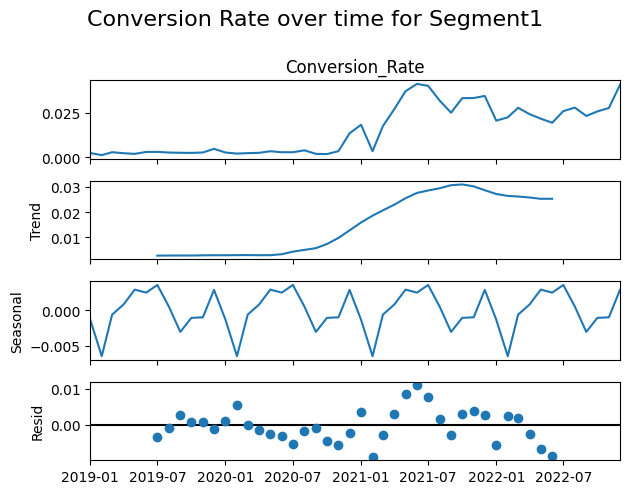

<ipython-input-336-cbbdf70c4815>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_dict[f"Segment{i+1}"].drop(columns=['Segment_ID'], inplace=True)


<Figure size 1200x800 with 0 Axes>

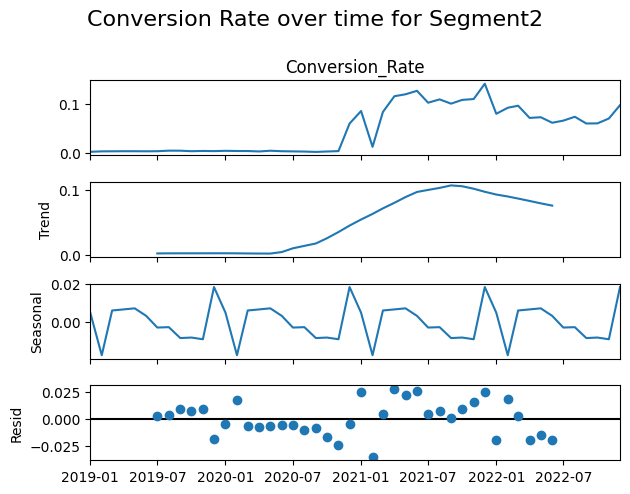

<ipython-input-336-cbbdf70c4815>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_dict[f"Segment{i+1}"].drop(columns=['Segment_ID'], inplace=True)


<Figure size 1200x800 with 0 Axes>

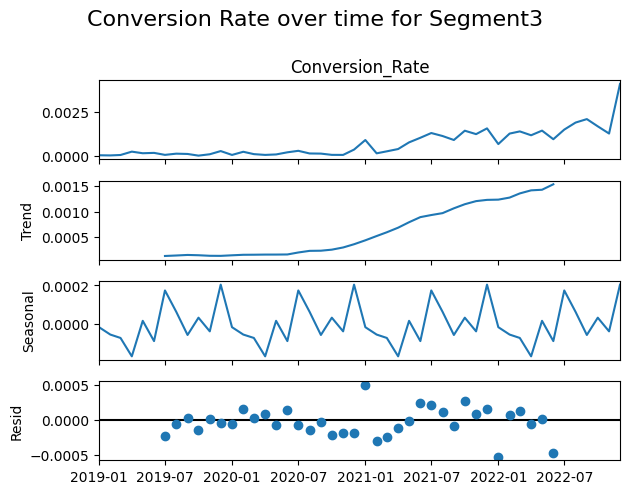

<ipython-input-336-cbbdf70c4815>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  segment_dict[f"Segment{i+1}"].drop(columns=['Segment_ID'], inplace=True)


<Figure size 1200x800 with 0 Axes>

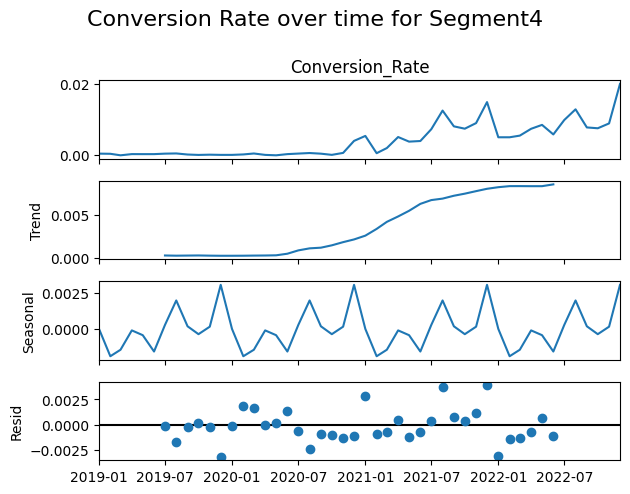

In [336]:
segment_dict = {}

for i in range(4):
  print("\n\n")
  segment_dict[f"Segment{i+1}"] = segments_all[segments_all['Segment_ID'] == i+1]
  segment_dict[f"Segment{i+1}"].drop(columns=['Segment_ID'], inplace=True)
  segment_dict[f"Segment{i+1}"].set_index('Year_Month', inplace=True)
  segment_dict[f"Segment{i+1}"] = segment_dict[f"Segment{i+1}"].sort_index(ascending=True)
  segment_dict[f"Segment{i+1}"].index = pd.to_datetime(segment_dict[f"Segment{i+1}"].index, format='%Y-%m')
  segment_dict[f"Segment{i+1}_resampled"] = segment_dict[f"Segment{i+1}"].resample('M').ffill()
  results = seasonal_decompose(segment_dict[f"Segment{i+1}"]['Conversion_Rate'])
  plt.figure(figsize=(12, 8))
  results.plot()
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.suptitle(f"Conversion Rate over time for Segment{i+1}", fontsize=16, y=1.02)
  plt.show()

--------

### **6.5.3 - Selecting Segment (from 1 to 4)**

In [394]:
ID = 4

(48, 1)
            Conversion_Rate
Year_Month                 
2019-01-01         0.000471
2019-02-01         0.000426
2019-03-01         0.000000
2019-04-01         0.000337
2019-05-01         0.000328


<Axes: xlabel='Year_Month'>

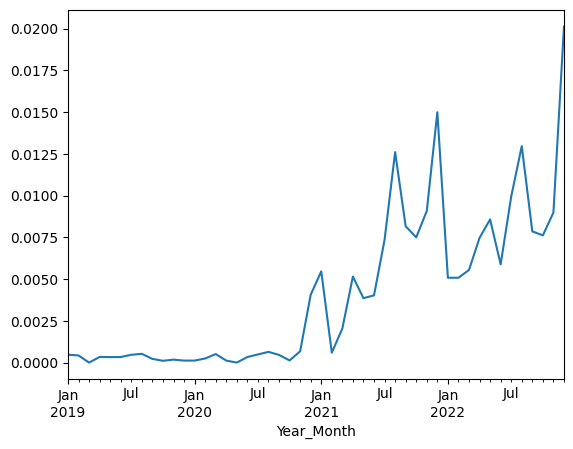

In [395]:
Seg_ID = segment_dict[f"Segment{ID}"]
print(Seg_ID.shape)
print(Seg_ID.head())
Seg_ID['Conversion_Rate'].plot()

In [396]:
segmentX = Seg_ID.copy()
segmentX.head()

,Conversion_Rate
Year_Month,
2019-01-01,0.000471
2019-02-01,0.000426
2019-03-01,0.000000
2019-04-01,0.000337
2019-05-01,0.000328


--------

### **6.5.4 - LSTM Model Creation**

In [397]:
def df_to_X_y(segmentX, window_size):
  df_as_np = segmentX.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np) - window_size):
    row = df_as_np[i:i+window_size]
    X.append(row) # Take current i plus window size (will actually take 1 less because of the range)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X) , np.array(y)

In [398]:
window_size = 14
X, y = df_to_X_y(segmentX, window_size)

X.shape , y.shape
# First value of the first tuple will be the total all lines on the analyzed dataframe MINUS the WINDOW_SIZE

((34, 14, 1), (34,))

### **6.5.5 - Dividing data**

In [401]:
X_train , y_train = X[:24] , y[:24]
X_val , y_val = X[24:30] , y[24:30]
X_test , y_test = X[30:] , y[30:] #29
X_train.shape , y_train.shape , X_val.shape , y_val.shape , X_test.shape , y_test.shape

((24, 14, 1), (24,), (6, 14, 1), (6,), (4, 14, 1), (4,))

In [402]:
window_y = segmentX.iloc[ : window_size]['Conversion_Rate']

window_indices = segmentX[ : window_size].index
train_indices = segmentX[window_size : window_size+24].index
val_indices = segmentX[window_size + 24: window_size + 30].index
test_indices = segmentX[window_size + 30:].index

In [403]:
# Defining model - Architecture 1

model1 = Sequential()
model1.add(InputLayer((window_size,1))) #window and variables
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))


model1.summary() #print model configurations

cp = ModelCheckpoint('model1/' , save_best_only = True) #I want to only save the best value that is the one with lowest validation loss
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, callbacks=[cp])


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 64)                16896     
                                                                 
 dense_20 (Dense)            (None, 8)                 520       
                                                                 
 dense_21 (Dense)            (None, 1)                 9         
                                                                 
Total params: 17425 (68.07 KB)
Trainable params: 17425 (68.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/30
1/1 [==============================] - 8s 8s/step - loss: 3.2883e-05 - root_mean_squared_error: 0.0057 - val_loss: 6.4968e-06 - val_root_mean_squared_error: 0.0025
Epoch 2/30
1/1 [==============================] - 4s 4s/step - loss: 2.2788e-05 - root_mean_squared_error:

In [404]:
model1 = load_model('model1/')

### **6.6.6 - Model evaluation on train,val,test**

**- Train Data**

In [405]:
train_predictions = model1.predict(X_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': train_predictions, 'Actual': y_train})
all_values_1 = pd.DataFrame(data={'Index' : train_indices , 'Model Step' : 'Training' , 'Model': train_predictions, 'Actual': y_train})
train_results.head()

1/1 [==============================] - 0s 450ms/step


,Train Predictions,Actual
0,0.006660,0.000510
1,0.006669,0.000118
2,0.006662,0.000000
3,0.006655,0.000333
4,0.006659,0.000488


- Validation Data

In [406]:
val_predictions = model1.predict(X_val).flatten()
val_results = pd.DataFrame(data={'Val Predictions': val_predictions, 'Actual': y_val})
all_values_2 = pd.DataFrame(data={'Index' : val_indices, 'Model Step' : 'Validation' , 'Model': val_predictions, 'Actual': y_val})
val_results.head()

1/1 [==============================] - 0s 26ms/step


,Val Predictions,Actual
0,0.008054,0.005547
1,0.007999,0.007472
2,0.008036,0.008575
3,0.008100,0.005882
4,0.008049,0.009945


- **Test Data**

In [407]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions': test_predictions, 'Actual': y_test})
all_values_3 = pd.DataFrame(data={'Index' : test_indices, 'Model Step' : 'Testing' , 'Model': test_predictions, 'Actual': y_test})
test_results.head()

rmse = sqrt(mean_squared_error(test_results['Actual'], test_results['Test Predictions']))
print(rmse)

# Will print a number that we can use to compare difference between models

1/1 [==============================] - 0s 43ms/step
0.005953327782569112


- **Data consolidation**

In [408]:
all_values_0 = pd.DataFrame(data={'Index': window_indices, 'Model Step': 'None', 'Model': np.nan, 'Actual': window_y})
all_values = pd.concat([all_values_0 , all_values_1, all_values_2, all_values_3], ignore_index=True)
all_values.set_index('Index', inplace=True)

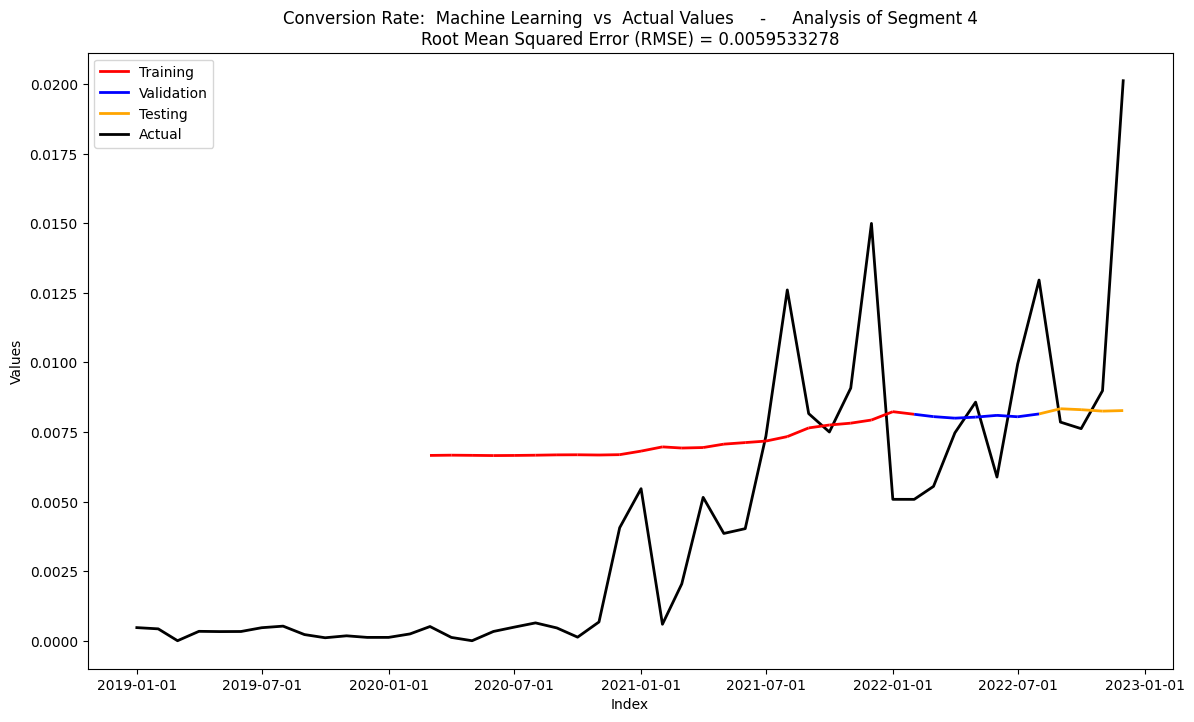

In [409]:
# Color map for the different Model Steps
step_colors = {
    'None': 'gray',
    'Training': 'red',
    'Validation': 'blue',
    'Testing': 'orange'
}

# Preparing segments with different colors
segments = []
colors = []
for i in range(1, len(all_values)):
    if not pd.isna(all_values['Model'].iloc[i-1]) and not pd.isna(all_values['Model'].iloc[i]):
        x_start = mdates.date2num(all_values.index[i-1])
        x_end = mdates.date2num(all_values.index[i])
        segments.append([(x_start, all_values['Model'].iloc[i-1]), (x_end, all_values['Model'].iloc[i])])
        colors.append(step_colors[all_values['Model Step'].iloc[i]])

# Plotting
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the Actual line in black
ax.plot(all_values.index, all_values['Actual'], label='Actual', color='black', linewidth=2)

# Create a LineCollection from the segments and add it to the plot
lc = LineCollection(segments, colors=colors, linewidths=2)
ax.add_collection(lc)

# Add legend
handles = [plt.Line2D([0], [0], color=color, linewidth=2, label=step) for step, color in step_colors.items() if step != 'None']
handles.append(plt.Line2D([0], [0], color='black', linewidth=2, label='Actual'))
ax.legend(handles=handles)

ax.set_xlabel('Index')
ax.set_ylabel('Values')
ax.set_title(f'Conversion Rate:  Machine Learning  vs  Actual Values     -     Analysis of Segment {ID}\nRoot Mean Squared Error (RMSE) = {round(rmse,10)}')

ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.show()

----